# 模型一

## 数据生成

In [19]:
import numpy as np
import pandas as pd
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap

def generate_quay_crane_data(num_tasks=10, num_cranes=3, num_bays=6, stability_threshold=2.0, seed=42):
    """
    生成岸桥调度问题的测试数据，确保岸桥初始位置不重叠，且所有岸桥处理能力相同
    
    参数:
    num_tasks: 任务数量
    num_cranes: 岸桥数量
    num_bays: 贝位数量
    stability_threshold: 稳定性阈值
    seed: 随机数种子
    
    返回:
    包含所有生成数据的字典
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # 检查基本参数合理性
    if num_cranes > num_bays:
        print("警告: 岸桥数量不能大于贝位数量，将岸桥数量调整为等于贝位数量")
        num_cranes = num_bays
    
    # 创建任务集合 N
    N = list(range(1, num_tasks + 1))

    # 创建岸桥集合 Q
    Q = list(range(1, num_cranes + 1))

    # 更均匀地生成任务位置 (贝位)
    bay_distribution = []
    for i in range(num_bays):
        bay_distribution.extend([i+1] * (num_tasks // num_bays))
    
    # 添加剩余任务
    remaining_tasks = num_tasks - len(bay_distribution)
    if remaining_tasks > 0:
        bay_distribution.extend(random.sample(range(1, num_bays+1), remaining_tasks))
    
    # 打乱顺序
    random.shuffle(bay_distribution)
    l_i = {i: bay_distribution[i-1] for i in N}

    # 确定任务类型（装船/卸船）
    unload_count = int(num_tasks * 0.6)
    task_types = ['unload'] * unload_count + ['load'] * (num_tasks - unload_count)
    random.shuffle(task_types)
    task_type = {i: task_types[i-1] for i in N}

    # 生成每个任务的固有工作量 - 这决定了任务需要的处理时间
    # 不同任务有不同的工作量，但每个岸桥的处理能力相同
    task_workloads = {i: random.randint(125, 175) for i in N}
    
    # 为所有岸桥分配相同的处理时间
    p_ik = {}
    for i in N:
        p_ik[i] = {k: task_workloads[i] for k in Q}

    # 岸桥的初始位置 - 确保不重叠
    available_positions = list(range(1, num_bays+1))
    random.shuffle(available_positions)
    q_k = {}
    
    # 确保每个岸桥有不同的初始位置
    for k in Q:
        q_k[k] = available_positions[k-1]
    
    # 岸桥之间的最小安全裕度
    g = 3  # 安全距离为1个贝位

    # 移动时间计算函数
    def calculate_time(pos1, pos2):
        return abs((pos1 - pos2))

    # 岸桥从初始位置到任务位置的移动时间
    t_prime_ik = {i: {k: calculate_time(l_i[i], q_k[k]) for k in Q} for i in N}

    # 岸桥从一个任务位置到另一个任务位置的移动时间
    t_ij = {(i, j): calculate_time(l_i[i], l_i[j]) for i in N for j in N if i != j}

    # 船舶稳定性参数 - 修剪值贡献
    d_i = {}
    ship_center = (num_bays + 1) / 2
    
    # 减小修剪值强度，使问题更容易满足稳定性约束
    intensity_factor = 0.9
    
    for i in N:
        # 位置偏离船舶中心，对修剪值的影响
        position_factor = (l_i[i] - ship_center) / (num_bays / 2)  # 归一化到[-1,1]
        
        # 随机生成任务的重量影响，使用更可控的范围
        weight_factor = random.uniform(0.5, 1.0)
        
        if task_type[i] == 'unload':
            # 卸船会减少重量，产生负修剪值
            d_i[i] = -position_factor * weight_factor * intensity_factor
        else:  # 'load'
            # 装船会增加重量，产生正修剪值
            d_i[i] = position_factor * weight_factor * intensity_factor

    # 使用传入的稳定性阈值
    H = stability_threshold

    # 调度时间跨度上限
    avg_processing_time = sum(task_workloads.values()) / len(N)
    tasks_per_crane = num_tasks / num_cranes
    estimated_makespan = avg_processing_time * tasks_per_crane * 3  # 添加50%缓冲
    T_0 = int(max(100, estimated_makespan))  # 确保足够的时间跨度

    # 生成任务优先级关系
    Phi = []
    for i in N:
        for j in N:
            if i != j and l_i[i] == l_i[j] and task_type[i] == 'unload' and task_type[j] == 'load':
                Phi.append((i, j))
    
    # # 限制优先级关系的数量，防止约束过多导致模型不可解
    # if len(Phi) > num_tasks // 3:
    #     Phi = random.sample(Phi, num_tasks // 3)

    # 生成潜在冲突集合 (Θ)
    Theta = []
    for i in N:
        for j in N:
            if i == j:
                continue
            for k in Q:
                for l in Q:
                    if k == l:
                        continue
                    # 考虑所有可能的交叉情况
                    if (l_i[i] <= l_i[j] and q_k[k] >= q_k[l]) or (l_i[i] >= l_i[j] and q_k[k] <= q_k[l]):
                        Theta.append((i, j, k, l))
    
    # # 如果冲突集合过大，进行采样
    # max_conflicts = num_tasks * num_cranes * 2
    # if len(Theta) > max_conflicts:
    #     Theta = random.sample(Theta, max_conflicts)

    # 将生成的数据整合到一个字典中
    data = {
        'N': N,  # 任务集合
        'Q': Q,  # 岸桥集合
        'l_i': l_i,  # 任务位置
        'task_type': task_type,  # 任务类型
        'p_ik': p_ik,  # 处理时间
        'q_k': q_k,  # 岸桥初始位置
        'g': g,  # 安全裕度
        't_prime_ik': t_prime_ik,  # 初始移动时间
        't_ij': t_ij,  # 任务间移动时间
        'd_i': d_i,  # 修剪值贡献
        'H': H,  # 稳定性阈值
        'T_0': T_0,  # 时间跨度上限
        'Phi': Phi,  # 优先级关系
        'Theta': Theta,  # 潜在冲突集合
        'num_bays': num_bays  # 贝位总数
    }

    # 打印数据统计信息
    print(f"生成数据统计:")
    print(f"任务数量: {num_tasks}, 岸桥数量: {num_cranes}, 贝位数量: {num_bays}")
    print(f"任务工作量范围: {min(task_workloads.values())}分钟 - {max(task_workloads.values())}分钟")
    print(f"平均处理时间: {avg_processing_time:.2f} 分钟")
    print(f"任务类型分布: 卸船={unload_count}, 装船={num_tasks-unload_count}")
    print(f"优先级关系数量: {len(Phi)}")
    print(f"潜在冲突数量: {len(Theta)}")
    print(f"估计完成时间: {estimated_makespan:.2f}, 设定时间跨度: {T_0}")
    print(f"修剪值范围: {min(d_i.values()):.3f} 到 {max(d_i.values()):.3f}, 稳定性阈值: {H}")
    
    # 验证稳定性约束是否可能满足
    verify_stability_feasibility(data)
    
    # 检查岸桥位置
    print(f"岸桥初始位置: {q_k}")
    position_counts = {}
    for pos in q_k.values():
        position_counts[pos] = position_counts.get(pos, 0) + 1
    
    has_overlap = any(count > 1 for count in position_counts.values())
    if has_overlap:
        print("警告: 岸桥初始位置存在重叠!")
    else:
        print("岸桥初始位置检查: 没有重叠")
        
    return data

def verify_stability_feasibility(data):
    """验证是否存在满足稳定性约束的理论可行解"""
    N = data['N']
    d_i = data['d_i']
    H = data['H']
    Phi = data['Phi']
    
    # 构建优先级图
    G = nx.DiGraph()
    for i in N:
        G.add_node(i)
    
    for i, j in Phi:
        G.add_edge(i, j)
    
    # 检查是否有环
    if not nx.is_directed_acyclic_graph(G):
        print("警告: 优先级关系中存在环，可能导致模型不可解")
        return False
        
    # 尝试通过任务交错排序来最小化最大修剪值
    pos_tasks = [i for i in N if d_i[i] > 0]
    neg_tasks = [i for i in N if d_i[i] <= 0]
    
    pos_tasks.sort(key=lambda i: d_i[i])
    neg_tasks.sort(key=lambda i: d_i[i], reverse=True)
    
    # 计算最优交错排序下的修剪值变化
    current_trim = 0
    max_abs_trim = 0
    trim_history = []
    
    # 贪心选择任务，尽量保持修剪值接近0
    sequence = []
    remaining_tasks = set(N)
    
    while remaining_tasks:
        best_task = None
        min_new_abs_trim = float('inf')
        
        for i in remaining_tasks:
            # 检查该任务是否有未完成的前置任务
            predecessors = set()
            for u, v in Phi:
                if v == i:
                    predecessors.add(u)
            
            if not all(p not in remaining_tasks for p in predecessors):
                continue  # 跳过有未完成前置任务的任务
                
            new_trim = current_trim + d_i[i]
            if abs(new_trim) < min_new_abs_trim:
                min_new_abs_trim = abs(new_trim)
                best_task = i
        
        if best_task is None:
            print("警告: 无法找到满足优先级约束的下一个任务，可能存在约束冲突")
            break
            
        # 添加选择的任务
        sequence.append(best_task)
        current_trim += d_i[best_task]
        trim_history.append((best_task, current_trim))
        max_abs_trim = max(max_abs_trim, abs(current_trim))
        remaining_tasks.remove(best_task)
    
    print(f"理论上最小可能的最大修剪值: {max_abs_trim:.3f}")
    print(f"稳定性阈值: {H}")
    
    if max_abs_trim > H:
        print("警告: 即使最优任务排序也无法满足稳定性约束，建议增加阈值或调整修剪值贡献")
        # 打印详细的序列和修剪值变化
        print("推荐的任务序列:")
        for task, trim in trim_history:
            print(f"任务 {task}: 修剪值变为 {trim:.3f}")
    else:
        print("验证通过: 存在理论可行的任务序列满足稳定性约束")
        
    return max_abs_trim <= H

# 保存数据为CSV文件方便查看和使用
def save_data_to_csv(data):
    # 指定保存路径
    save_dir = r"C:\Users\27497\Desktop\毕业设计\代码\Data"
    
    # 确保目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 保存任务信息
    tasks_df = pd.DataFrame({
        'task_id': data['N'],
        'bay_position': [data['l_i'][i] for i in data['N']],
        'task_type': [data['task_type'][i] for i in data['N']],
        'trim_contribution': [data['d_i'][i] for i in data['N']]
    })
    tasks_df.to_csv(os.path.join(save_dir, 'tasks_data.csv'), index=False)

    # 保存处理时间
    processing_times = []
    for i in data['N']:
        for k in data['Q']:
            processing_times.append({
                'task_id': i,
                'crane_id': k,
                'processing_time': data['p_ik'][i][k]
            })
    pd.DataFrame(processing_times).to_csv(os.path.join(save_dir, 'processing_times.csv'), index=False)

    # 保存岸桥信息
    cranes_df = pd.DataFrame({
        'crane_id': data['Q'],
        'initial_position': [data['q_k'][k] for k in data['Q']]
    })
    cranes_df.to_csv(os.path.join(save_dir, 'cranes_data.csv'), index=False)

    # 保存优先级关系
    if data['Phi']:
        phi_df = pd.DataFrame(data['Phi'], columns=['task_i', 'task_j'])
        phi_df.to_csv(os.path.join(save_dir, 'priority_relations.csv'), index=False)

    # 保存基本参数
    params_df = pd.DataFrame([{
        'num_tasks': len(data['N']),
        'num_cranes': len(data['Q']),
        'num_bays': data['num_bays'],
        'safety_margin': data['g'],
        'stability_threshold': data['H'],
        'time_horizon': data['T_0']
    }])
    params_df.to_csv(os.path.join(save_dir, 'parameters.csv'), index=False)


### 运行

In [20]:
# 生成数据
data = generate_quay_crane_data(num_tasks=50, num_cranes=3, num_bays=20, stability_threshold=300, seed=42)

# 保存数据
save_data_to_csv(data)

print("数据生成完成并保存为CSV文件")

生成数据统计:
任务数量: 50, 岸桥数量: 3, 贝位数量: 20
任务工作量范围: 125分钟 - 175分钟
平均处理时间: 152.34 分钟
任务类型分布: 卸船=30, 装船=20
优先级关系数量: 20
潜在冲突数量: 7590
估计完成时间: 7617.00, 设定时间跨度: 7617
修剪值范围: -0.803 到 0.738, 稳定性阈值: 300
理论上最小可能的最大修剪值: 5.764
稳定性阈值: 300
验证通过: 存在理论可行的任务序列满足稳定性约束
岸桥初始位置: {1: 20, 2: 19, 3: 17}
岸桥初始位置检查: 没有重叠
数据生成完成并保存为CSV文件


## 生成数据可视化

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
from matplotlib import cm
import datetime

def load_data():
    """Load saved CSV data from Data directory"""
    # 直接指定数据目录的绝对路径
    data_dir = r"C:\Users\27497\Desktop\毕业设计\代码\Data"
    
    # 从Data目录加载文件
    tasks_df = pd.read_csv(os.path.join(data_dir, 'tasks_data.csv'))
    cranes_df = pd.read_csv(os.path.join(data_dir, 'cranes_data.csv'))
    params_df = pd.read_csv(os.path.join(data_dir, 'parameters.csv'))
    processing_df = pd.read_csv(os.path.join(data_dir, 'processing_times.csv'))
    
    print(f"数据从 {data_dir} 目录成功加载")
    return tasks_df, cranes_df, params_df, processing_df

def visualize_ship_and_tasks_horizontal(tasks_df, cranes_df, params_df, processing_df=None):
    """
    以横向布局可视化船舶，贝位，任务和岸桥，使用计算机顶会论文的高级风格
    显示每个任务的处理时间
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patches as patches
    import datetime
    import os
    from matplotlib import rcParams
    
    # 设置学术风格配置
    plt.style.use('seaborn-v0_8-whitegrid')
    rcParams['font.family'] = 'Arial'
    rcParams['font.size'] = 11
    rcParams['axes.titlesize'] = 14
    rcParams['axes.labelsize'] = 12
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    
    num_bays = params_df['num_bays'].values[0]
    
    # 计算每个任务的处理时间（所有岸桥处理能力相同，所以取任意一个）
    task_times = {}
    if processing_df is not None:
        for _, row in processing_df.iterrows():
            task_id = row['task_id']
            if task_id not in task_times:  # 只取第一个岸桥的时间（所有岸桥相同）
                task_times[task_id] = row['processing_time']
    
    # 设置更大的图形和更高的DPI以获得学术质量的清晰度
    plt.figure(figsize=(12, 7), dpi=150, facecolor='white')
    
    # 创建主轴对象
    ax = plt.gca()
    
    # 定义专业的学术风格配色方案
    ship_color = '#e6eef4'  # 更柔和的浅蓝灰色
    ship_edge_color = '#2c3e50'  # 深青灰色，更专业
    bay_line_color = '#95a5a6'  # 雅致的中灰色
    grid_color = '#ecf0f1'  # 更浅的灰色，不刺眼
    
    # 学术论文风格的任务类型颜色方案
    task_colors = {
        'unload': '#3498db',  # 柔和的蓝色
        'load': '#e67e22'     # 柔和的橙色
    }
    
    # 为岸桥创建颜色映射 - 使用学术风格配色
    academic_colors = ['#4e79a7', '#f28e2b', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f']
    crane_color_map = {k: academic_colors[i % len(academic_colors)] for i, k in enumerate(cranes_df['crane_id'])}
    
    # 设置背景样式
    ax.set_facecolor('#f9f9f9')  # 轻微的灰色背景
    ax.grid(True, axis='x', linestyle='-', color='#e0e0e0', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    # 绘制网格线
    ax.grid(True, axis='x', linestyle='--', alpha=0.3, color=grid_color)
    
    # 绘制船舶外形 - 横向布局
    ship_height = num_bays + 1  # 船的高度对应贝位数
    ship_width = 4  # 船的宽度
    left = 0
    bottom = 0
    
    # 创建船身
    ship_body = patches.Rectangle((left, bottom), ship_width, ship_height,
                                 edgecolor=ship_edge_color, facecolor=ship_color,
                                 alpha=0.7, linewidth=1.5, zorder=1)
    ax.add_patch(ship_body)
    
    # 绘制贝位分隔线
    for i in range(1, num_bays + 1):
        plt.axhline(y=i, linestyle='--', color=bay_line_color, 
                   alpha=0.5, linewidth=0.8, zorder=2)
    
    # 设置Y轴刻度为贝位编号
    y_ticks = list(range(1, num_bays + 1))
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'Bay {i}' for i in y_ticks])
    
    # 确保贝位按照自下而上排列（与crane_schedule_by_bay一致）
    ax.set_ylim(0, num_bays + 1)
    
    # 标记船首和船尾 - 使用学术风格文本框
    plt.text(ship_width / 2, 0.3, 'Bow', ha='center', va='center',
            fontsize=10, color='#333333', fontweight='medium', zorder=5,
            bbox=dict(facecolor='white', edgecolor='#cccccc', alpha=0.9,
                     boxstyle='round,pad=0.2'))
    plt.text(ship_width / 2, num_bays + 0.7, 'Stern', ha='center', va='center',
            fontsize=10, color='#333333', fontweight='medium', zorder=5,
            bbox=dict(facecolor='white', edgecolor='#cccccc', alpha=0.9,
                     boxstyle='round,pad=0.2'))
    
    # 按贝位分组任务，以避免重叠
    bay_tasks = tasks_df.groupby('bay_position')
    
    # 绘制任务 - 保持形状不变，只调整颜色
    task_markers = {'unload': 's', 'load': '^'}  # 使用方形和三角形标记
    
    for bay, bay_group in bay_tasks:
        num_tasks = len(bay_group)
        task_spacing = ship_width / (num_tasks + 1)
        
        for i, (_, task) in enumerate(bay_group.iterrows()):
            task_id = task['task_id']
            task_type = task['task_type']
            trim_contrib = task['trim_contribution']
            processing_time = task_times.get(task_id, "N/A")  # 获取处理时间
            
            # 计算位置（水平分布在船内）
            x_pos = task_spacing * (i + 1)
            y_pos = bay  # 贝位位置
            
            # 绘制任务标记 - 保持形状，调整颜色和边缘
            plt.scatter(x_pos, y_pos, s=150, color=task_colors[task_type],
                       marker=task_markers[task_type], edgecolor='#555555', linewidth=0.8,
                       zorder=3, alpha=0.85)
            
            # 添加任务ID和处理时间标签 - 优化文本框样式
            label_text = f"T{task_id}\n({processing_time}min)"
            plt.text(x_pos, y_pos + 0.3, label_text, ha='center', va='bottom',
                    fontsize=9, color='#333333', fontweight='medium', zorder=5,
                    bbox=dict(facecolor='#f8f8f8', edgecolor='#cccccc', alpha=0.95,
                             boxstyle='round,pad=0.2'))
            
            # 添加修剪值贡献 - 更专业的字体和颜色
            trim_text = f"Trim: {trim_contrib:.2f}"
            plt.text(x_pos - 0.3, y_pos, trim_text, ha='center', va='top', fontsize=8,
                    color='#666666', zorder=5)
    
    # 绘制岸桥初始位置 - 保持形状，调整颜色
    for _, crane in cranes_df.iterrows():
        crane_id = crane['crane_id']
        position = crane['initial_position']
        
        # 将岸桥绘制在船外
        crane_x = ship_width + 1
        crane_y = position
        
        # 绘制岸桥 - 调整颜色和边缘
        plt.scatter(crane_x, crane_y, s=200, marker='D', color=crane_color_map[crane_id],
                   edgecolor='#555555', linewidth=0.8, zorder=4)
        
        # 添加岸桥标签 - 优化文本框
        plt.text(crane_x, crane_y + 0.3, f'Crane {crane_id}', ha='center', va='bottom',
                fontsize=9, color='#333333', fontweight='medium', zorder=5,
                bbox=dict(facecolor='#f8f8f8', edgecolor='#cccccc', alpha=0.95,
                         boxstyle='round,pad=0.2'))
    
    # 添加图例 - 使用学术风格图例
    unload_patch = patches.Patch(color=task_colors['unload'], label='Unloading Task')
    load_patch = patches.Patch(color=task_colors['load'], label='Loading Task')
    
    legend = plt.legend(handles=[unload_patch, load_patch],
                       loc='upper right', framealpha=0.9, edgecolor='#dddddd',
                       fontsize=9, title='Task Types', title_fontsize=10)
    legend.set_zorder(10)
    
    # 添加统计信息文本框 - 使用学术风格文本框
    stats_text = (
        f"Statistics:\n"
        f"Number of Bays: {num_bays}\n"
        f"Number of Tasks: {len(tasks_df)}\n"
        f"  - Unload: {sum(tasks_df['task_type'] == 'unload')}\n"
        f"  - Load: {sum(tasks_df['task_type'] == 'load')}\n"
        f"Number of Cranes: {len(cranes_df)}"
    )
    
    props = dict(boxstyle='round,pad=0.4', facecolor='#f8f8f8',
                edgecolor='#cccccc', alpha=0.95, linewidth=0.8)
    plt.text(0.9, 0.2, stats_text, transform=ax.transAxes, fontsize=9,
            color='#333333', verticalalignment='top', zorder=10, bbox=props)
    
    # 添加时间戳和引用 - 使用更专业的字体和颜色
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    footer_text = f"Generated: {current_time} | Quay Crane Scheduling Model"
    plt.text(0.99, 0.01, footer_text, transform=ax.transAxes, fontsize=7,
            color='#888888', ha='right', va='bottom', zorder=5)
    
    # 设置标题 - 更专业的样式
    plt.title('Container Ship Bay Layout and Task Distribution',
             fontsize=14, fontweight='bold', color='#333333', pad=10)
    
    # 设置坐标轴标签 - 更专业的样式
    plt.xlabel('Ship Width', fontsize=11, color='#333333', fontweight='semibold')
    plt.ylabel('Bay Position', fontsize=11, color='#333333', fontweight='semibold')
    
    # 调整X轴范围，给岸桥留出足够空间
    plt.xlim(-0.5, ship_width + 3)
    
    # 优化布局
    plt.tight_layout()
    
    # 创建输出目录
    output_dir = r"C:\Users\27497\Desktop\毕业设计\代码\Data"
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存图像
    output_path = os.path.join(output_dir, 'ship_and_tasks_academic.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')
    print(f"学术风格可视化结果保存为 '{output_path}'")
    
    plt.show()

def main():
    """加载数据并以横向布局可视化船舶和任务"""
    print("加载数据...")
    tasks_df, cranes_df, params_df, processing_df = load_data()
    print("数据加载成功!")

    print("生成横向船舶和任务分布可视化...")
    visualize_ship_and_tasks_horizontal(tasks_df, cranes_df, params_df, processing_df)
    print("可视化完成!")


### 运行

加载数据...
数据从 C:\Users\27497\Desktop\毕业设计\代码\Data 目录成功加载
数据加载成功!
生成横向船舶和任务分布可视化...
学术风格可视化结果保存为 'C:\Users\27497\Desktop\毕业设计\代码\Data\ship_and_tasks_academic.png'


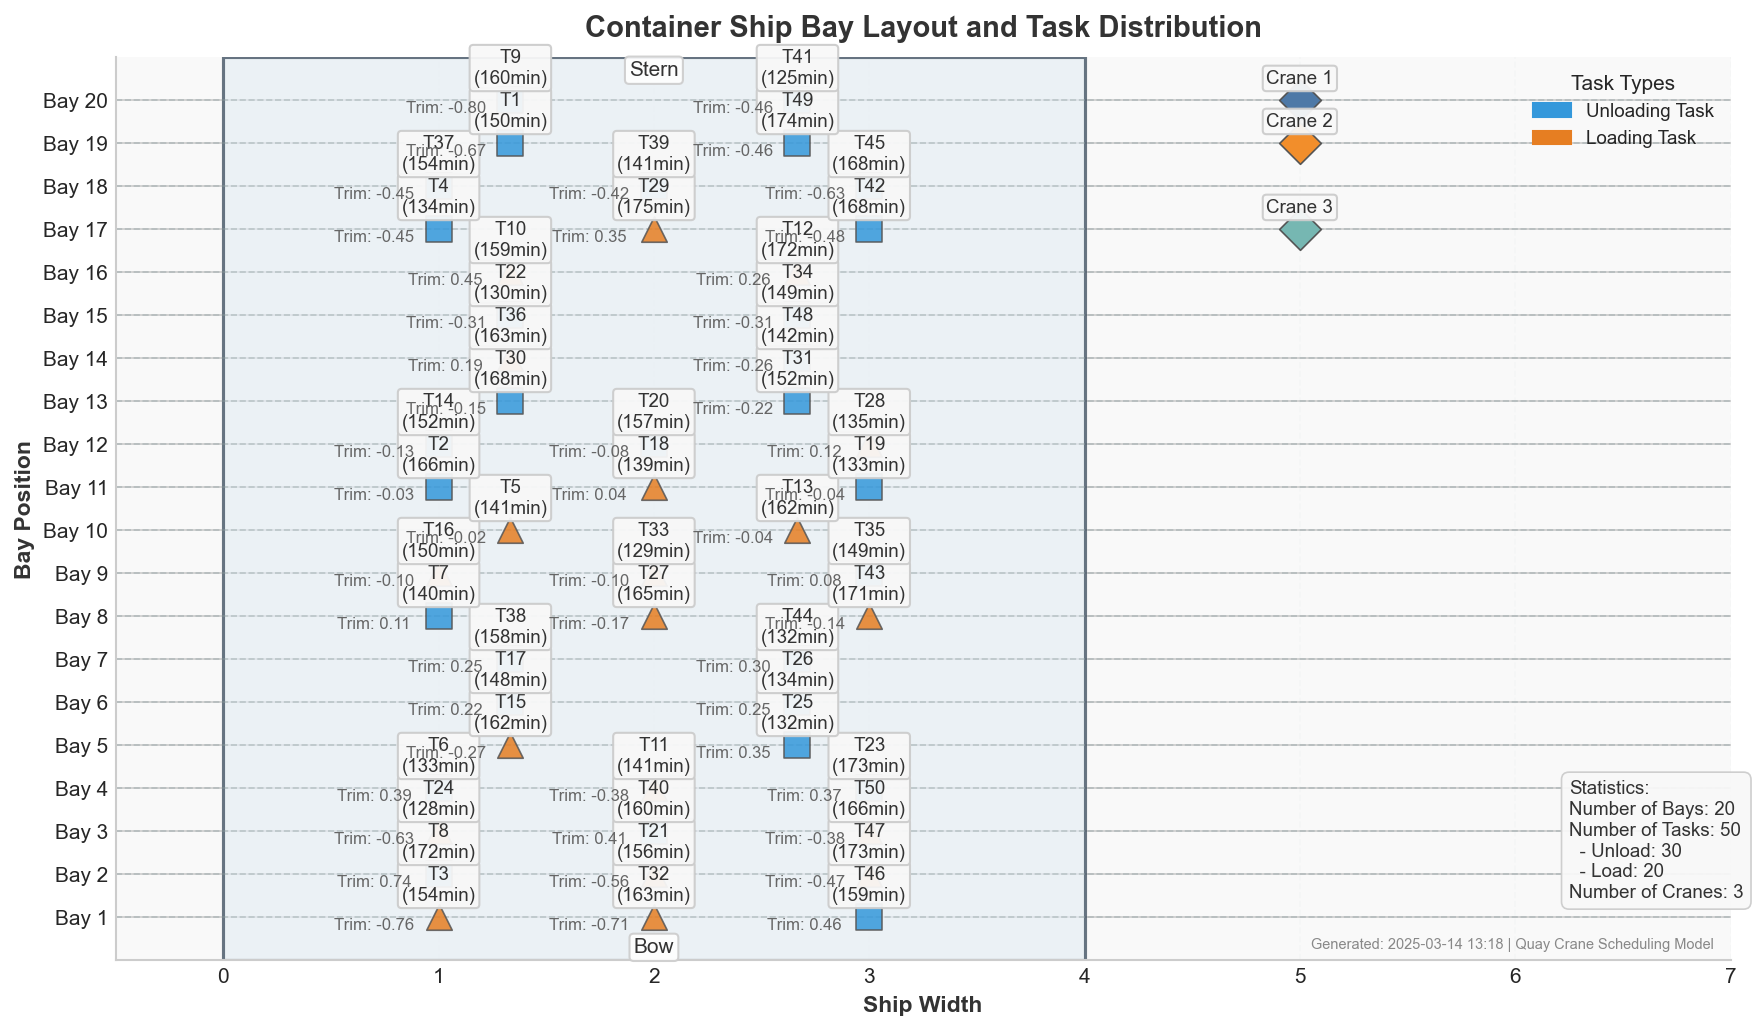

可视化完成!


In [22]:
main()

## 求解器求解

In [ ]:
import math

def solve_quay_crane_scheduling_with_breaks(data, with_stability=True, with_breaks=True):
    """
    增强版岸桥调度求解器 - 多阶段求解流程
    1. 先求解带工作休息约束的模型
    2. 检验解是否满足稳定性约束
    3. 如不满足，添加稳定性约束重新求解
    4. 如仍无解，扩大稳定性阈值再次尝试
    
    参数:
    data: 包含问题数据的字典
    with_stability: 是否检验稳定性约束(默认: True)
    with_breaks: 是否启用岸桥工作休息约束(默认: True)
    
    返回:
    包含解决方案详情的字典
    """
    import time
    import gurobipy as gp
    from gurobipy import GRB
    import copy
    
    print(f"构建岸桥调度模型 - 多阶段求解 (工作休息约束: {with_breaks}, 稳定性约束检验: {with_stability})")
    overall_start_time = time.time()
    
    # 提取数据
    N = data['N']  # 任务集合
    Q = data['Q']  # 岸桥集合
    Phi = data['Phi']  # 优先级关系
    Theta = data['Theta']  # 潜在冲突
    p_ik = data['p_ik']  # 处理时间
    t_prime_ik = data['t_prime_ik']  # 初始移动时间
    t_ij = data['t_ij']  # 任务间移动时间
    g = data['g']  # 安全裕度
    l_i = data['l_i']  # 任务位置
    d_i = data['d_i']  # 修剪值贡献
    H = data['H']  # 稳定性阈值
    T_0 = data['T_0']  # 时间跨度上限
    
    # 工作休息相关参数
    work_duration = 480  # 8小时 = 480分钟
    break_duration = 30  # 30分钟休息
    min_work_after_break = 420  # 休息后至少工作1小时才能再次休息
    
    # 第一阶段：求解包含工作休息约束的基本模型（不考虑稳定性约束）
    def solve_phase1():
        print("\n第一阶段：求解包含工作休息约束的基本模型（不考虑稳定性约束）")
        start_time_phase1 = time.time()
        
        # 创建模型
        model = gp.Model("Quay_Crane_Scheduling_Phase1")
        
        # 设置大M值（优化后）
        M = T_0 * 2  # 使用时间跨度上限的两倍作为更紧凑的边界
        
        print("创建基本决策变量...")
        
        # 基本决策变量
        C_max = model.addVar(vtype=GRB.CONTINUOUS, name="C_max")
        s = {i: model.addVar(vtype=GRB.CONTINUOUS, name=f"s_{i}", lb=0) for i in N}
        c = {i: model.addVar(vtype=GRB.CONTINUOUS, name=f"c_{i}", lb=0) for i in N}
        x = {(i, k): model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{k}") for i in N for k in Q}
        y = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}") for i in N for j in N if i != j}
        
        # 设置目标函数
        model.setObjective(C_max, GRB.MINIMIZE)
        
        print("添加基本约束...")
        
        # 定义最大完成时间
        for i in N:
            model.addConstr(C_max >= c[i], name=f"C_max_def_{i}")
        
        # 每个任务分配给一台岸桥
        for i in N:
            model.addConstr(gp.quicksum(x[i, k] for k in Q) == 1, name=f"assign_{i}")
        
        # 计算任务完成时间
        for i in N:
            model.addConstr(c[i] == s[i] + gp.quicksum(p_ik[i][k] * x[i, k] for k in Q), 
                           name=f"completion_{i}")
        
        # 强制每对任务的顺序
        for i in N:
            for j in N:
                if i < j:  # 每对任务只创建一次约束
                    model.addConstr(y[i, j] + y[j, i] == 1, name=f"order_exclusive_{i}_{j}")
        
        # 岸桥初始移动时间
        for i in N:
            for k in Q:
                model.addConstr(s[i] >= t_prime_ik[i][k] * x[i, k], name=f"initial_move_{i}_{k}")
        
        # 优先级约束
        for i, j in Phi:
            model.addConstr(c[i] <= s[j], name=f"priority_{i}_{j}")
            model.addConstr(y[i, j] == 1, name=f"y_priority_{i}_{j}")
        
        print("添加非重叠和非交叉约束...")
        
        # 同一岸桥的任务不能重叠
        for i in N:
            for j in N:
                if i != j:
                    for k in Q:
                        # 如果任务i和j都分配给岸桥k，且i在j之前，
                        # 那么j必须在i完成后加上移动时间才能开始
                        model.addConstr(
                            s[j] >= c[i] + t_ij[(i, j)] - M * (3 - x[i, k] - x[j, k] - y[i, j]),
                            name=f"no_overlap_{i}_{j}_{k}"
                        )
        
        # 岸桥非交叉约束
        for i, j, k, l in Theta:
            # 如果任务i使用岸桥k，任务j使用岸桥l，且i在j之前，
            # 那么j必须在i完成后加上安全裕度才能开始
            model.addConstr(
                s[j] >= c[i] + g - M * (3 - x[i, k] - x[j, l] - y[i, j]),
                name=f"no_crossing_{i}_{j}_{k}_{l}"
            )
        
        # 岸桥工作休息约束实现
        if with_breaks:
            print("添加岸桥工作休息约束...")
            
            # 估计工作周期数量 - 基于总工作时间
            total_task_time = sum(sum(p_ik[i].values()) / len(Q) for i in N)
            estimated_periods_per_crane = max(2, int(total_task_time / work_duration) + 1)
            max_periods = min(10, estimated_periods_per_crane + 2)  # 控制工作周期数量
            
            print(f"最大工作周期数: {max_periods} (每个岸桥)")
            
            # 工作周期集合 P
            P = list(range(1, max_periods + 1))
            
            # 创建工作周期变量
            work_start = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"work_start_{k}_{p}", lb=0)
                         for k in Q for p in P}
            work_end = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"work_end_{k}_{p}", lb=0)
                       for k in Q for p in P}
            break_start = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"break_start_{k}_{p}", lb=0)
                          for k in Q for p in P if p < max_periods}
            break_end = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"break_end_{k}_{p}", lb=0)
                        for k in Q for p in P if p < max_periods}
            
            # 工作周期使用标志
            period_used = {(k, p): model.addVar(vtype=GRB.BINARY, name=f"period_used_{k}_{p}")
                          for k in Q for p in P}
            
            # 任务分配到工作周期
            z = {(i, k, p): model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{k}_{p}")
                for i in N for k in Q for p in P}
            
            # 工作周期时长约束
            for k in Q:
                for p in P:
                    # 工作周期最长8小时
                    model.addConstr(
                        work_end[k, p] - work_start[k, p] <= work_duration,
                        name=f"work_duration_{k}_{p}"
                    )
                    
                    # 如果工作周期不被使用，其开始和结束时间为0
                    model.addConstr(
                        work_end[k, p] <= M * period_used[k, p],
                        name=f"unused_period_end_{k}_{p}"
                    )
                    model.addConstr(
                        work_start[k, p] <= M * period_used[k, p],
                        name=f"unused_period_start_{k}_{p}"
                    )
                    
                    # 添加最小工作时间约束 (对于非最后一个工作周期)
                    # 这可以防止工作时间过短就休息的情况
                    if p < max_periods:
                        # 如果使用了下一个工作周期，当前周期必须至少工作一定时间
                        model.addConstr(
                            work_end[k, p] - work_start[k, p] >= min_work_after_break * period_used[k, p+1],
                            name=f"min_work_time_{k}_{p}"
                        )
            
            # 休息时长约束
            for k in Q:
                for p in P:
                    if p < max_periods:
                        # 休息时长30分钟 - 只有当下一个工作周期被使用时才强制休息
                        model.addConstr(
                            break_end[k, p] - break_start[k, p] == break_duration * period_used[k, p+1],
                            name=f"break_duration_{k}_{p}"
                        )
                        
                        # 如果不使用下一个工作周期，则不需要休息
                        model.addConstr(
                            break_end[k, p] <= M * period_used[k, p+1],
                            name=f"unused_break_end_{k}_{p}"
                        )
                        model.addConstr(
                            break_start[k, p] <= M * period_used[k, p+1],
                            name=f"unused_break_start_{k}_{p}"
                        )
            
            # 工作与休息衔接约束
            for k in Q:
                for p in P:
                    if p < max_periods:
                        # 休息开始于工作结束 - 只当下一个工作周期被使用时才强制约束
                        model.addConstr(
                            break_start[k, p] == work_end[k, p],
                            name=f"work_break_connect_{k}_{p}"
                        )
                        # 下一工作周期开始于休息结束
                        model.addConstr(
                            work_start[k, p+1] == break_end[k, p],
                            name=f"break_work_connect_{k}_{p}"
                        )
            
            # 工作周期顺序约束
            for k in Q:
                for p in range(1, max_periods):
                    # 第p+1工作周期只能在第p工作周期被使用时使用
                    model.addConstr(
                        period_used[k, p+1] <= period_used[k, p],
                        name=f"period_order_{k}_{p}"
                    )
            
            # 任务分配与工作周期关联约束
            for i in N:
                for k in Q:
                    # 任务i分配给岸桥k的某个工作周期
                    model.addConstr(
                        gp.quicksum(z[i, k, p] for p in P) == x[i, k],
                        name=f"task_to_period_{i}_{k}"
                    )
                    
                    # 具体到每个工作周期
                    for p in P:
                        # 如果任务i分配给岸桥k的工作周期p，则任务必须在该工作周期内完成
                        model.addConstr(
                            s[i] >= work_start[k, p] - M * (1 - z[i, k, p]),
                            name=f"task_after_period_start_{i}_{k}_{p}"
                        )
                        model.addConstr(
                            c[i] <= work_end[k, p] + M * (1 - z[i, k, p]),
                            name=f"task_before_period_end_{i}_{k}_{p}"
                        )
                        
                        # 任务只能分配给使用的工作周期
                        model.addConstr(
                            z[i, k, p] <= period_used[k, p],
                            name=f"task_to_used_period_{i}_{k}_{p}"
                        )
            
            # 防止休息时间重叠 - 连续休息的情况
            for k in Q:
                for p1 in range(1, max_periods-1):
                    for p2 in range(p1+1, max_periods):
                        # 两个休息时间之间必须有足够的工作时间
                        # 如果两个工作周期都被使用
                        model.addConstr(
                            work_end[k, p2] - break_end[k, p1] >= 
                            min_work_after_break * period_used[k, p1+1] * period_used[k, p2+1],
                            name=f"prevent_consecutive_breaks_{k}_{p1}_{p2}"
                        )
        
        # 添加有效不等式约束以提高求解效率
        print("添加有效不等式约束...")
        
        # 1. 岸桥工作负荷平衡约束
        total_workload = sum(sum(p_ik[i].values())/len(Q) for i in N)
        avg_crane_workload = total_workload / len(Q)
        
        for k in Q:
            model.addConstr(
                gp.quicksum(p_ik[i][k] * x[i, k] for i in N) <= avg_crane_workload * 1.5,
                name=f"workload_balance_upper_{k}"
            )
            model.addConstr(
                gp.quicksum(p_ik[i][k] * x[i, k] for i in N) >= avg_crane_workload * 0.5,
                name=f"workload_balance_lower_{k}"
            )
        
        # 2. 估计最小完工时间
        min_makespan = total_workload / len(Q)
        if with_breaks:
            # 考虑休息时间的影响
            breaks_count = int(min_makespan / work_duration)
            min_makespan += breaks_count * break_duration
        
        model.addConstr(C_max >= min_makespan, name="min_makespan")
        
        # 求解模型
        print(f"求解第一阶段模型（{model.NumVars}个变量和{model.NumConstrs}个约束）...")
        model.setParam('TimeLimit', 120)  # 2分钟时限
        model.setParam('MIPGap', 0.05)
        model.setParam('FeasibilityTol', 1e-5)
        model.setParam('IntFeasTol', 1e-5)
        
        # 设置求解器参数以提高效率
        model.setParam('Presolve', 2)  # 更积极的预解
        model.setParam('Heuristics', 0.7)  # 增加启发式强度
        model.setParam('MIPFocus', 1)  # 关注可行解
        
        # 开启并行计算
        model.setParam('Threads', 0)  # 使用所有可用线程
        
        # 为了存储多个解，我们设置解池参数
        if with_stability:
            model.setParam('PoolSolutions', 10)  # 保存最多10个可行解
            model.setParam('PoolSearchMode', 2)  # 寻找高质量可行解
        
        model.optimize()
        
        # 处理第一阶段结果
        phase1_time = time.time() - start_time_phase1
        print(f"第一阶段求解完成，用时: {phase1_time:.2f}秒")
        
        if model.status != GRB.OPTIMAL and model.status != GRB.TIME_LIMIT and model.SolCount == 0:
            print(f"第一阶段未找到可行解。状态: {model.status}")
            return None, {'status': model.status, 'message': "找不到可行解", 'solve_time': phase1_time}
        
        print(f"第一阶段找到 {model.SolCount} 个可行解")
        
        # 获取所有可行解
        solutions = []
        
        # 正确地访问解池中的解
        if with_stability and model.SolCount > 1:
            # 获取多个解用于稳定性检测
            for sol_idx in range(min(10, model.SolCount)):
                # 设置当前解索引
                model.setParam('SolutionNumber', sol_idx)
                
                sol = {}
                sol['makespan'] = model.PoolObjVal
                
                # 获取变量值
                sol['assignments'] = {}
                sol['start_times'] = {}
                sol['completion_times'] = {}
                
                for i in N:
                    # 寻找任务i被分配给哪个岸桥
                    for k in Q:
                        if x[i, k].Xn > 0.5:
                            sol['assignments'][i] = k
                            break
                    
                    # 获取开始和完成时间
                    sol['start_times'][i] = s[i].Xn
                    sol['completion_times'][i] = c[i].Xn
                
                if with_breaks:
                    # 收集工作周期信息
                    periods_info = {}
                    for k in Q:
                        periods_info[k] = []
                        for p in P:
                            if period_used[k, p].Xn > 0.5:
                                period_data = {
                                    'period': p,
                                    'work_start': work_start[k, p].Xn,
                                    'work_end': work_end[k, p].Xn,
                                    'tasks': []
                                }
                                
                                # 如果不是最后一个工作周期，添加休息时间
                                if p < max_periods and period_used[k, p+1].Xn > 0.5:
                                    period_data['break_start'] = break_start[k, p].Xn
                                    period_data['break_end'] = break_end[k, p].Xn
                                
                                # 收集该工作周期内的任务
                                for i in N:
                                    if i in sol['assignments'] and sol['assignments'][i] == k:
                                        try:
                                            if z[i, k, p].Xn > 0.5:
                                                period_data['tasks'].append({
                                                    'task': i,
                                                    'start': sol['start_times'][i],
                                                    'completion': sol['completion_times'][i],
                                                    'duration': sol['completion_times'][i] - sol['start_times'][i]
                                                })
                                        except:
                                            # 如果变量不存在则跳过
                                            continue
                                
                                periods_info[k].append(period_data)
                    
                    sol['periods_info'] = periods_info
                
                solutions.append(sol)
        else:
            # 只获取最优解
            sol = {}
            sol['makespan'] = model.ObjVal
            sol['assignments'] = {i: next(k for k in Q if x[i, k].X > 0.5) for i in N}
            sol['start_times'] = {i: s[i].X for i in N}
            sol['completion_times'] = {i: c[i].X for i in N}
            
            if with_breaks:
                # 收集工作周期信息
                periods_info = {}
                for k in Q:
                    periods_info[k] = []
                    for p in P:
                        if period_used[k, p].X > 0.5:
                            period_data = {
                                'period': p,
                                'work_start': work_start[k, p].X,
                                'work_end': work_end[k, p].X,
                                'tasks': []
                            }
                            
                            # 如果不是最后一个工作周期且下一个周期被使用，添加休息时间
                            if p < max_periods and period_used[k, p+1].X > 0.5:
                                period_data['break_start'] = break_start[k, p].X
                                period_data['break_end'] = break_end[k, p].X
                            
                            # 收集该工作周期内的任务
                            for i in N:
                                if i in sol['assignments'] and sol['assignments'][i] == k:
                                    try:
                                        if z[i, k, p].X > 0.5:
                                            period_data['tasks'].append({
                                                'task': i,
                                                'start': sol['start_times'][i],
                                                'completion': sol['completion_times'][i],
                                                'duration': sol['completion_times'][i] - sol['start_times'][i]
                                            })
                                    except:
                                        # 如果变量不存在则跳过
                                        continue
                            
                            periods_info[k].append(period_data)
                
                sol['periods_info'] = periods_info
            
            solutions.append(sol)
        
        return model, solutions  # 返回模型以及解
    
    # 第二阶段：检验解是否满足稳定性约束
    def check_stability(solutions, stability_threshold):
        print("\n第二阶段：检验解是否满足稳定性约束")
        start_time_phase2 = time.time()
        
        valid_solutions = []
        
        for idx, sol in enumerate(solutions):
            print(f"检验解 {idx+1}/{len(solutions)}，makespan = {sol['makespan']:.2f}")
            
            # 计算完整的修剪值历史
            event_times = set()
            event_times.add(0)  # 添加初始时间点
            
            for i in N:
                start_i = sol['start_times'][i]
                end_i = sol['completion_times'][i]
                event_times.add(start_i)
                event_times.add(end_i)
                
                # 为每个任务添加中间时间点，使修剪值变化更平滑
                duration = end_i - start_i
                if duration > 0:
                    for step in range(1, 21):  # 20个中间点
                        intermediate_time = start_i + (duration * step / 20)
                        event_times.add(intermediate_time)
            
            # 如果启用了工作休息约束，添加休息时间点
            if with_breaks and 'periods_info' in sol:
                for k in Q:
                    if k in sol['periods_info']:
                        for period in sol['periods_info'][k]:
                            if 'break_start' in period:
                                event_times.add(period['break_start'])
                                event_times.add(period['break_end'])
            
            # 将时间点排序
            sorted_times = sorted(event_times)
            
            # 计算每个时间点的修剪值
            events = []
            max_abs_trim = 0
            
            for t in sorted_times:
                # 对于每个时间点，计算所有任务的累积贡献
                current_trim = 0
                
                for i in N:
                    start_i = sol['start_times'][i]
                    end_i = sol['completion_times'][i]
                    duration = end_i - start_i
                    
                    # 如果任务尚未开始，不贡献修剪值
                    if t < start_i:
                        continue
                    # 如果任务已经完成，贡献全部修剪值
                    elif t >= end_i:
                        current_trim += d_i[i]
                    # 如果任务正在进行中，按比例贡献修剪值
                    else:
                        progress = (t - start_i) / duration if duration > 0 else 1.0
                        current_trim += d_i[i] * progress
                
                # 确定事件类型
                event_type = "time_point"
                for i in N:
                    if abs(t - sol['start_times'][i]) < 1e-6:
                        event_type = f"start_{i}"
                        break
                    elif abs(t - sol['completion_times'][i]) < 1e-6:
                        event_type = f"end_{i}"
                        break
                
                # 检查是否为休息时间点
                if with_breaks and 'periods_info' in sol:
                    for k in Q:
                        if k in sol['periods_info']:
                            for period in sol['periods_info'][k]:
                                if 'break_start' in period and abs(t - period['break_start']) < 1e-6:
                                    event_type = f"break_start_{k}"
                                    break
                                elif 'break_end' in period and abs(t - period['break_end']) < 1e-6:
                                    event_type = f"break_end_{k}"
                                    break
                
                events.append((t, current_trim, event_type))
                max_abs_trim = max(max_abs_trim, abs(current_trim))
            
            # 记录修剪值结果
            sol['trim_history'] = events
            sol['max_trim'] = max_abs_trim
            sol['trim_within_threshold'] = max_abs_trim <= stability_threshold + 1e-5
            
            print(f"  最大修剪值: {max_abs_trim:.4f} (阈值: {stability_threshold})")
            
            # 如果满足稳定性约束，添加到有效解列表
            if sol['trim_within_threshold']:
                print(f"  该解满足稳定性约束!")
                valid_solutions.append(sol)
            else:
                print(f"  该解不满足稳定性约束")
        
        phase2_time = time.time() - start_time_phase2
        return valid_solutions, phase2_time 
    
    # 第三阶段：添加稳定性约束重新求解
    def solve_with_stability_constraints(current_threshold):
        print(f"\n第三阶段：添加稳定性约束重新求解 (阈值: {current_threshold})")
        start_time_phase3 = time.time()
        
        # 创建新模型（含稳定性约束）
        model = gp.Model("Quay_Crane_Scheduling_With_Stability")
        
        # 设置大M值
        M = T_0 * 2
        
        print("创建决策变量...")
        
        # 基本决策变量
        C_max = model.addVar(vtype=GRB.CONTINUOUS, name="C_max")
        s = {i: model.addVar(vtype=GRB.CONTINUOUS, name=f"s_{i}", lb=0) for i in N}
        c = {i: model.addVar(vtype=GRB.CONTINUOUS, name=f"c_{i}", lb=0) for i in N}
        x = {(i, k): model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{k}") for i in N for k in Q}
        y = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}") for i in N for j in N if i != j}
        
        # 添加用于稳定性的变量
        # 时间点集
        time_points = model.addVars(N, vtype=GRB.CONTINUOUS, name="time_points")
        # 每个时间点的修剪值
        trim_values = model.addVars(N, lb=-float('inf'), ub=float('inf'), vtype=GRB.CONTINUOUS, name="trim_values")
        # 每个任务在每个时间点是否完成的标志
        completed = {(i, t): model.addVar(vtype=GRB.BINARY, name=f"completed_{i}_{t}") 
                    for i in N for t in N}
        # 最大修剪值绝对值
        max_trim = model.addVar(vtype=GRB.CONTINUOUS, name="max_trim")
        
        # 设置目标函数
        model.setObjective(C_max, GRB.MINIMIZE)
        
        # 添加基本约束
        print("添加基本约束...")
        
        # 定义最大完成时间
        for i in N:
            model.addConstr(C_max >= c[i], name=f"C_max_def_{i}")
        
        # 每个任务分配给一台岸桥
        for i in N:
            model.addConstr(gp.quicksum(x[i, k] for k in Q) == 1, name=f"assign_{i}")
        
        # 计算任务完成时间
        for i in N:
            model.addConstr(c[i] == s[i] + gp.quicksum(p_ik[i][k] * x[i, k] for k in Q), 
                        name=f"completion_{i}")
        
        # 强制每对任务的顺序
        for i in N:
            for j in N:
                if i < j:  # 每对任务只创建一次约束
                    model.addConstr(y[i, j] + y[j, i] == 1, name=f"order_exclusive_{i}_{j}")
        
        # 岸桥初始移动时间
        for i in N:
            for k in Q:
                model.addConstr(s[i] >= t_prime_ik[i][k] * x[i, k], name=f"initial_move_{i}_{k}")
        
        # 优先级约束
        for i, j in Phi:
            model.addConstr(c[i] <= s[j], name=f"priority_{i}_{j}")
            model.addConstr(y[i, j] == 1, name=f"y_priority_{i}_{j}")
        
        # 同一岸桥的任务不能重叠
        for i in N:
            for j in N:
                if i != j:
                    for k in Q:
                        model.addConstr(
                            s[j] >= c[i] + t_ij[(i, j)] - M * (3 - x[i, k] - x[j, k] - y[i, j]),
                            name=f"no_overlap_{i}_{j}_{k}"
                        )
        
        # 岸桥非交叉约束
        for i, j, k, l in Theta:
            model.addConstr(
                s[j] >= c[i] + g - M * (3 - x[i, k] - x[j, l] - y[i, j]),
                name=f"no_crossing_{i}_{j}_{k}_{l}"
            )
        
        # 岸桥工作休息约束实现
        if with_breaks:
            print("添加岸桥工作休息约束...")
            
            # 估计工作周期数量 - 基于总工作时间
            total_task_time = sum(sum(p_ik[i].values()) / len(Q) for i in N)
            estimated_periods_per_crane = max(2, int(total_task_time / work_duration) + 1)
            max_periods = min(10, estimated_periods_per_crane + 2)  # 控制工作周期数量
            
            print(f"最大工作周期数: {max_periods} (每个岸桥)")
            
            # 工作周期集合 P
            P = list(range(1, max_periods + 1))
            
            # 创建工作周期变量
            work_start = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"work_start_{k}_{p}", lb=0)
                        for k in Q for p in P}
            work_end = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"work_end_{k}_{p}", lb=0)
                    for k in Q for p in P}
            break_start = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"break_start_{k}_{p}", lb=0)
                        for k in Q for p in P if p < max_periods}
            break_end = {(k, p): model.addVar(vtype=GRB.CONTINUOUS, name=f"break_end_{k}_{p}", lb=0)
                        for k in Q for p in P if p < max_periods}
            
            # 工作周期使用标志
            period_used = {(k, p): model.addVar(vtype=GRB.BINARY, name=f"period_used_{k}_{p}")
                        for k in Q for p in P}
            
            # 任务分配到工作周期
            z = {(i, k, p): model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{k}_{p}")
                for i in N for k in Q for p in P}
            
            # 工作周期时长约束
            for k in Q:
                for p in P:
                    # 工作周期最长8小时
                    model.addConstr(
                        work_end[k, p] - work_start[k, p] <= work_duration,
                        name=f"work_duration_{k}_{p}"
                    )
                    
                    # 如果工作周期不被使用，其开始和结束时间为0
                    model.addConstr(
                        work_end[k, p] <= M * period_used[k, p],
                        name=f"unused_period_end_{k}_{p}"
                    )
                    model.addConstr(
                        work_start[k, p] <= M * period_used[k, p],
                        name=f"unused_period_start_{k}_{p}"
                    )
                    
                    # 添加最小工作时间约束 (对于非最后一个工作周期)
                    if p < max_periods:
                        model.addConstr(
                            work_end[k, p] - work_start[k, p] >= min_work_after_break * period_used[k, p+1],
                            name=f"min_work_time_{k}_{p}"
                        )
            
            # 休息时长约束
            for k in Q:
                for p in P:
                    if p < max_periods:
                        # 休息时长30分钟 - 只有当下一个工作周期被使用时才强制休息
                        model.addConstr(
                            break_end[k, p] - break_start[k, p] == break_duration * period_used[k, p+1],
                            name=f"break_duration_{k}_{p}"
                        )
                        
                        # 如果不使用下一个工作周期，则不需要休息
                        model.addConstr(
                            break_end[k, p] <= M * period_used[k, p+1],
                            name=f"unused_break_end_{k}_{p}"
                        )
                        model.addConstr(
                            break_start[k, p] <= M * period_used[k, p+1],
                            name=f"unused_break_start_{k}_{p}"
                        )
            
            # 工作与休息衔接约束
            for k in Q:
                for p in P:
                    if p < max_periods:
                        # 休息开始于工作结束
                        model.addConstr(
                            break_start[k, p] == work_end[k, p],
                            name=f"work_break_connect_{k}_{p}"
                        )
                        # 下一工作周期开始于休息结束
                        model.addConstr(
                            work_start[k, p+1] == break_end[k, p],
                            name=f"break_work_connect_{k}_{p}"
                        )
            
            # 工作周期顺序约束
            for k in Q:
                for p in range(1, max_periods):
                    model.addConstr(
                        period_used[k, p+1] <= period_used[k, p],
                        name=f"period_order_{k}_{p}"
                    )
            
            # 任务分配与工作周期关联约束
            for i in N:
                for k in Q:
                    model.addConstr(
                        gp.quicksum(z[i, k, p] for p in P) == x[i, k],
                        name=f"task_to_period_{i}_{k}"
                    )
                    
                    for p in P:
                        model.addConstr(
                            s[i] >= work_start[k, p] - M * (1 - z[i, k, p]),
                            name=f"task_after_period_start_{i}_{k}_{p}"
                        )
                        model.addConstr(
                            c[i] <= work_end[k, p] + M * (1 - z[i, k, p]),
                            name=f"task_before_period_end_{i}_{k}_{p}"
                        )
                        
                        model.addConstr(
                            z[i, k, p] <= period_used[k, p],
                            name=f"task_to_used_period_{i}_{k}_{p}"
                        )
            
            # 防止休息时间重叠
            for k in Q:
                for p1 in range(1, max_periods-1):
                    for p2 in range(p1+1, max_periods):
                        model.addConstr(
                            work_end[k, p2] - break_end[k, p1] >= 
                            min_work_after_break * period_used[k, p1+1] * period_used[k, p2+1],
                            name=f"prevent_consecutive_breaks_{k}_{p1}_{p2}"
                        )
        
        # 添加稳定性约束 - 这是第三阶段的关键
        print("添加稳定性约束...")
        
        # 设置时间点为任务完成时间
        for t in N:
            model.addConstr(time_points[t] == c[t], name=f"time_point_{t}")
        
        # 建立任务完成标志变量 - 使用二进制变量表示任务是否在时间点前完成
        for i in N:
            for t in N:
                # 如果 c[i] <= time_points[t]，则 completed[i, t] = 1
                model.addConstr(c[i] - time_points[t] <= M * (1 - completed[i, t]), 
                            name=f"completed_{i}_{t}_upper")
                model.addConstr(c[i] - time_points[t] >= -M * completed[i, t] + 0.001 * (1 - completed[i, t]), 
                            name=f"completed_{i}_{t}_lower")
        
        # 计算每个时间点的修剪值 - 使用二进制变量
        for t_idx in N:
            model.addConstr(
                trim_values[t_idx] == gp.quicksum(
                    d_i[i] * completed[i, t_idx] for i in N
                ),
                name=f"trim_value_at_{t_idx}"
            )
            
            # 设置最大修剪值约束
            model.addConstr(trim_values[t_idx] <= current_threshold, name=f"trim_upper_bound_{t_idx}")
            model.addConstr(trim_values[t_idx] >= -current_threshold, name=f"trim_lower_bound_{t_idx}")
            
            # 跟踪最大绝对值
            model.addConstr(max_trim >= trim_values[t_idx], name=f"max_trim_upper_{t_idx}")
            model.addConstr(max_trim >= -trim_values[t_idx], name=f"max_trim_lower_{t_idx}")
        
        # 添加效率约束
        print("添加效率约束...")
        
        total_workload = sum(sum(p_ik[i].values())/len(Q) for i in N)
        avg_crane_workload = total_workload / len(Q)
        
        for k in Q:
            model.addConstr(
                gp.quicksum(p_ik[i][k] * x[i, k] for i in N) <= avg_crane_workload * 1.5,
                name=f"workload_balance_upper_{k}"
            )
            model.addConstr(
                gp.quicksum(p_ik[i][k] * x[i, k] for i in N) >= avg_crane_workload * 0.5,
                name=f"workload_balance_lower_{k}"
            )
        
        min_makespan = total_workload / len(Q)
        if with_breaks:
            breaks_count = int(min_makespan / work_duration)
            min_makespan += breaks_count * break_duration
        
        model.addConstr(C_max >= min_makespan, name="min_makespan")
        
        # 求解模型
        print(f"求解第三阶段模型（{model.NumVars}个变量和{model.NumConstrs}个约束）...")
        model.setParam('TimeLimit', 600)  
        model.setParam('MIPGap', 0.05)
        model.setParam('FeasibilityTol', 1e-5)
        model.setParam('IntFeasTol', 1e-5)
        
        # 设置求解器参数
        model.setParam('Presolve', 2)
        model.setParam('Heuristics', 0.7)
        model.setParam('MIPFocus', 1)
        model.setParam('Threads', 0)
        
        model.optimize()
        
        phase3_time = time.time() - start_time_phase3
        print(f"第三阶段求解完成，用时: {phase3_time:.2f}秒")
        
        if model.status != GRB.OPTIMAL and model.status != GRB.TIME_LIMIT or model.SolCount == 0:
            print(f"第三阶段未找到可行解。状态: {model.status}")
            return None, {'status': model.status, 'message': f"无法找到满足稳定性约束的解 (阈值: {current_threshold})", 'solve_time': phase3_time}
        
        # 获取解
        sol = {}
        sol['makespan'] = model.ObjVal
        sol['max_trim'] = max_trim.X
        sol['trim_within_threshold'] = sol['max_trim'] <= current_threshold + 1e-5
        sol['assignments'] = {i: next(k for k in Q if x[i, k].X > 0.5) for i in N}
        sol['start_times'] = {i: s[i].X for i in N}
        sol['completion_times'] = {i: c[i].X for i in N}
        
        if with_breaks:
            # 收集工作周期信息
            periods_info = {}
            for k in Q:
                periods_info[k] = []
                for p in P:
                    if period_used[k, p].X > 0.5:
                        period_data = {
                            'period': p,
                            'work_start': work_start[k, p].X,
                            'work_end': work_end[k, p].X,
                            'tasks': []
                        }
                        
                        # 如果不是最后一个工作周期且下一个周期被使用，添加休息时间
                        if p < max_periods and period_used[k, p+1].X > 0.5:
                            period_data['break_start'] = break_start[k, p].X
                            period_data['break_end'] = break_end[k, p].X
                        
                        # 收集该工作周期内的任务
                        for i in N:
                            if i in sol['assignments'] and sol['assignments'][i] == k:
                                try:
                                    if z[i, k, p].X > 0.5:
                                        period_data['tasks'].append({
                                            'task': i,
                                            'start': sol['start_times'][i],
                                            'completion': sol['completion_times'][i],
                                            'duration': sol['completion_times'][i] - sol['start_times'][i]
                                        })
                                except:
                                    # 如果变量不存在则跳过
                                    continue
                        
                        periods_info[k].append(period_data)
            
            sol['periods_info'] = periods_info
        
        # 计算修剪值历史
        event_times = set()
        event_times.add(0)  # 添加初始时间点
        
        for i in N:
            start_i = sol['start_times'][i]
            end_i = sol['completion_times'][i]
            event_times.add(start_i)
            event_times.add(end_i)
            
            # 为每个任务添加中间时间点，使修剪值变化更平滑
            duration = end_i - start_i
            if duration > 0:
                for step in range(1, 21):  # 20个中间点
                    intermediate_time = start_i + (duration * step / 20)
                    event_times.add(intermediate_time)
        
        # 如果启用了工作休息约束，添加休息时间点
        if with_breaks and 'periods_info' in sol:
            for k in Q:
                if k in sol['periods_info']:
                    for period in sol['periods_info'][k]:
                        if 'break_start' in period:
                            event_times.add(period['break_start'])
                            event_times.add(period['break_end'])
        
        # 将时间点排序
        sorted_times = sorted(event_times)
        
        # 计算每个时间点的修剪值
        events = []
        max_abs_trim = 0
        
        for t in sorted_times:
            # 对于每个时间点，计算所有任务的累积贡献
            current_trim = 0
            
            for i in N:
                start_i = sol['start_times'][i]
                end_i = sol['completion_times'][i]
                duration = end_i - start_i
                
                # 如果任务尚未开始，不贡献修剪值
                if t < start_i:
                    continue
                # 如果任务已经完成，贡献全部修剪值
                elif t >= end_i:
                    current_trim += d_i[i]
                # 如果任务正在进行中，按比例贡献修剪值
                else:
                    progress = (t - start_i) / duration if duration > 0 else 1.0
                    current_trim += d_i[i] * progress
            
            # 确定事件类型
            event_type = "time_point"
            for i in N:
                if abs(t - sol['start_times'][i]) < 1e-6:
                    event_type = f"start_{i}"
                    break
                elif abs(t - sol['completion_times'][i]) < 1e-6:
                    event_type = f"end_{i}"
                    break
            
            # 检查是否为休息时间点
            if with_breaks and 'periods_info' in sol:
                for k in Q:
                    if k in sol['periods_info']:
                        for period in sol['periods_info'][k]:
                            if 'break_start' in period and abs(t - period['break_start']) < 1e-6:
                                event_type = f"break_start_{k}"
                                break
                            elif 'break_end' in period and abs(t - period['break_end']) < 1e-6:
                                event_type = f"break_end_{k}"
                                break
            
            events.append((t, current_trim, event_type))
            max_abs_trim = max(max_abs_trim, abs(current_trim))
        
        # 记录修剪值结果
        sol['trim_history'] = events
        sol['max_trim'] = max_abs_trim  # 更新为精确计算的值
        sol['trim_within_threshold'] = max_abs_trim <= current_threshold + 1e-5
        
        return sol, {'status': model.status, 'solve_time': phase3_time}

    # 主求解流程 - 多阶段求解
    # 第一阶段：求解带工作休息约束的模型
    model, phase1_solutions = solve_phase1()

    if not phase1_solutions:
        return {'status': GRB.INFEASIBLE, 'message': "找不到可行解", 'solve_time': time.time() - overall_start_time}

    # 如果不需要检验稳定性约束，直接返回第一个解
    if not with_stability:
        best_solution = phase1_solutions[0]
        best_solution['solve_time'] = time.time() - overall_start_time
        best_solution['status'] = model.status
        return best_solution

    # 第二阶段：检验解是否满足稳定性约束
    valid_solutions, phase2_time = check_stability(phase1_solutions, H)

    if valid_solutions:
        print(f"\n找到 {len(valid_solutions)} 个满足稳定性约束的解")
        # 按makespan排序
        valid_solutions.sort(key=lambda x: x['makespan'])
        best_solution = valid_solutions[0]
        print(f"选择最优解，makespan = {best_solution['makespan']:.2f}")
        
        best_solution['stability_check_time'] = phase2_time
        best_solution['solve_time'] = time.time() - overall_start_time
        best_solution['status'] = GRB.OPTIMAL
        best_solution['stability_satisfied'] = True
        
        return best_solution

    # 第三阶段：如果没有满足稳定性约束的解，添加稳定性约束重新求解
    print("\n未找到满足稳定性约束的解，进入第三阶段：添加稳定性约束重新求解")
    sol_with_stability, phase3_info = solve_with_stability_constraints(H)

    # 如果第三阶段找到解，直接返回
    if sol_with_stability:
        sol_with_stability['solve_time'] = time.time() - overall_start_time
        sol_with_stability['status'] = phase3_info['status']
        sol_with_stability['stability_satisfied'] = True
        return sol_with_stability

    # 第四阶段：如果仍无解，扩大稳定性阈值再试
    print("\n第四阶段：放宽稳定性阈值，再次求解")
    relaxed_H = H * 2  # 扩大为原来的两倍
    print(f"将稳定性阈值从 {H} 增大到 {relaxed_H}")

    sol_with_relaxed_stability, phase4_info = solve_with_stability_constraints(relaxed_H)

    # 如果第四阶段找到解，返回
    if sol_with_relaxed_stability:
        sol_with_relaxed_stability['solve_time'] = time.time() - overall_start_time
        sol_with_relaxed_stability['status'] = phase4_info['status']
        sol_with_relaxed_stability['stability_satisfied'] = True
        sol_with_relaxed_stability['stability_threshold_relaxed'] = True
        sol_with_relaxed_stability['original_threshold'] = H
        sol_with_relaxed_stability['relaxed_threshold'] = relaxed_H
        return sol_with_relaxed_stability

    # 如果所有尝试都失败，返回第一阶段的最优解，但标记为不满足稳定性约束
    print("\n所有阶段都未找到满足稳定性约束的解，返回工作休息约束的基本解")
    best_solution = phase1_solutions[0]  # 取第一个解作为最优解
    best_solution['solve_time'] = time.time() - overall_start_time
    best_solution['status'] = model.status
    best_solution['stability_satisfied'] = False
    best_solution['reason'] = "所有稳定性约束尝试失败"

    return best_solution

def visualize_crane_schedule_with_breaks(data, result):
    """
    可视化岸桥调度，以贝位为纵轴，展示岸桥轨迹，包含工作休息时间
    采用学术论文级别的配色方案和布局
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.lines import Line2D
    import matplotlib.patches as patches
    from matplotlib import rcParams
    
    # 设置学术风格配置
    plt.style.use('seaborn-v0_8-whitegrid')
    rcParams['font.family'] = 'Arial'
    rcParams['font.size'] = 11
    rcParams['axes.titlesize'] = 14
    rcParams['axes.labelsize'] = 12
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    
    # 提取数据
    N = data['N']
    Q = data['Q']
    l_i = data['l_i']  # 任务贝位位置
    q_k = data['q_k']  # 岸桥初始位置
    
    # 创建画布 - 使用16:9的比例更符合现代学术展示
    plt.figure(figsize=(12, 7), dpi=150, facecolor='white')
    ax = plt.gca()
    
    # 学术论文级别的配色方案
    # 使用ColorBrewer方案，适合区分不同类别的专业色彩
    color_palettes = [
        ['#4e79a7', '#f28e2b', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f'],  # Tableau
        ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],  # D3
        ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']   # Set2
    ]
    colors = color_palettes[0]  # 选择第一个配色方案
    color_map = {k: colors[i % len(colors)] for i, k in enumerate(Q)}
    
    # 获取贝位的最小和最大值
    all_bays = sorted(set(l_i.values()))
    min_bay = min(all_bays) - 1
    max_bay = max(all_bays) + 1
    
    # 设置背景样式
    ax.set_facecolor('#f9f9f9')  # 轻微的灰色背景
    ax.grid(True, axis='x', linestyle='-', color='#e0e0e0', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    # 按照岸桥分组任务，并按时间排序
    crane_tasks = {k: [] for k in Q}
    for i in N:
        crane = result['assignments'][i]
        crane_tasks[crane].append((i, result['start_times'][i], result['completion_times'][i]))
    
    for k in Q:
        crane_tasks[k].sort(key=lambda x: x[1])  # 按开始时间排序
    
    # 绘制任务条形图
    for i in N:
        crane = result['assignments'][i]
        bay = l_i[i]
        start = result['start_times'][i]
        duration = result['completion_times'][i] - start
        
        # 绘制任务条形 - 更细致的条形样式
        rect = ax.barh(bay, duration, left=start, height=0.65, 
                      color=color_map[crane], edgecolor='#555555', 
                      alpha=0.85, zorder=3)
        
        # 添加任务标签 - 更清晰的标签样式
        ax.text(start + duration/2, bay, f'{i}', 
                ha='center', va='center', color='white', fontweight='bold',
                fontsize=9, zorder=4)
    
    # 获取时间范围
    max_time = max(result['completion_times'].values()) * 1.05  # 添加5%的余量
    
    # 绘制岸桥轨迹和休息时间
    for k in Q:
        tasks = crane_tasks[k]
        if not tasks:
            continue
            
        # 起始点：岸桥初始位置
        initial_pos = q_k[k]
        times = [0]  # 开始于时间0
        positions = [initial_pos]
        
        # 检查是否有工作周期信息
        has_breaks = 'periods_info' in result and k in result['periods_info']
        
        # 添加该岸桥处理的所有任务的位置
        for i, start_time, end_time in tasks:
            bay = l_i[i]
            times.extend([start_time, end_time])
            positions.extend([bay, bay])
        
        # 绘制岸桥轨迹 - 更专业的线条样式
        ax.plot(times, positions, '-', color=color_map[k], linewidth=1.8, 
                marker='o', markersize=3.5, label=f'Crane {k}', alpha=0.9, zorder=2)
        
        # 显示岸桥初始位置
        ax.plot([0], [initial_pos], 'o', color=color_map[k], markersize=8, 
                markeredgecolor='#555555', markeredgewidth=1.2, zorder=5)
        
        # 绘制休息时间 - 更专业、低调的表示
        if has_breaks:
            for period in result['periods_info'][k]:
                if 'break_start' in period and 'break_end' in period:
                    break_start = period['break_start']
                    break_end = period['break_end']
                    
                    # 查找休息前后最近的任务位置来确定休息位置
                    break_position = None
                    
                    # 检查休息前的最后一个任务
                    for i, start_time, end_time in tasks:
                        if abs(end_time - break_start) < 1e-6:
                            break_position = l_i[i]
                            break
                    
                    # 如果找不到，检查休息后的第一个任务
                    if break_position is None:
                        for i, start_time, end_time in tasks:
                            if abs(start_time - break_end) < 1e-6:
                                break_position = l_i[i]
                                break
                    
                    # 如果都找不到，使用前后任务平均位置或初始位置
                    if break_position is None:
                        tasks_before = [t for t in tasks if t[2] <= break_start]
                        tasks_after = [t for t in tasks if t[1] >= break_end]
                        
                        if tasks_before and tasks_after:
                            last_before = max(tasks_before, key=lambda x: x[2])
                            first_after = min(tasks_after, key=lambda x: x[1])
                            break_position = (l_i[last_before[0]] + l_i[first_after[0]]) / 2
                        elif tasks_before:
                            last_before = max(tasks_before, key=lambda x: x[2])
                            break_position = l_i[last_before[0]]
                        elif tasks_after:
                            first_after = min(tasks_after, key=lambda x: x[1])
                            break_position = l_i[first_after[0]]
                        else:
                            break_position = initial_pos
                    
                    # 绘制休息时间 - 使用更优雅、不突兀的样式
                    # 颜色使用与岸桥颜色协调但区分度高的阴影色
                    break_color = color_map[k]
                    ax.plot([break_start, break_end], [break_position, break_position], 
                           '--', linewidth=2.2, color=break_color, alpha=0.75, zorder=4)
                    
                    # 休息开始和结束点使用实心方块，不使用文本标注
                    ax.plot([break_start, break_end], [break_position, break_position], 
                           's', markersize=5, color=break_color, alpha=0.9,
                           markeredgecolor='#555555', markeredgewidth=0.8, zorder=5)
                    
                    # 添加半透明休息区域标记而不是文本框
                    ax.axvspan(break_start, break_end, ymin=(break_position-0.3)/max_bay, 
                              ymax=(break_position+0.3)/max_bay,
                              color=break_color, alpha=0.1, zorder=1)
    
    # 设置Y轴为贝位 - 更专业的标签
    ax.set_yticks(all_bays)
    ax.set_yticklabels([f'Bay {b}' for b in all_bays])
    ax.set_ylim(min_bay, max_bay)
    
    # 设置X轴范围，确保显示完整
    ax.set_xlim(0, max_time)
    
    # 添加标签和标题 - 更专业的字体样式
    ax.set_ylabel('Bay Position', fontsize=12, color='#333333', fontweight='semibold')
    ax.set_xlabel('Time (minutes)', fontsize=12, color='#333333', fontweight='semibold')
    ax.set_title('Quay Crane Scheduling with Working/Break Periods', 
                fontsize=14, color='#333333', fontweight='bold', pad=10)
    
    # 添加图例 - 更高级的图例样式
    legend_elements = [Line2D([0], [0], color=color_map[k], lw=2, marker='o',
                              markersize=5, label=f'Crane {k}') for k in Q]
    
    # 断线表示休息时间
    legend_elements.append(Line2D([0], [0], color='#666666', lw=1.5, linestyle='--',
                                 marker='s', markersize=5, label='Break'))
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
              facecolor='white', edgecolor='#dddddd', framealpha=0.95,
              fontsize=9, title='Legend', title_fontsize=10)
    
    # 添加总结信息 - 更专业的样式
    summary_text = (
        f"Total Makespan: {result['makespan']:.2f} minutes\n"
        f"Number of Tasks: {len(N)}"
    )
    
    if 'trim_within_threshold' in result:
        threshold_status = "Yes" if result['trim_within_threshold'] else "No"
        summary_text += f"\nStability Constraint: {threshold_status}"
        if 'max_trim' in result:
            summary_text += f"\nMax Trim: {result['max_trim']:.2f} (Threshold: {data['H']})"
    
    # 使用更专业的信息框样式
    ax.text(0.01, 0.99, summary_text,
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.4', fc='#f8f8f8', ec='#cccccc', alpha=0.9),
            fontsize=9, color='#333333')
    
    # 优化布局
    plt.tight_layout()
    plt.savefig("crane_schedule_academic.png", dpi=300, bbox_inches='tight', format='png')
    print("Academic-style crane schedule visualization saved to crane_schedule_academic.png")
    plt.show()

def visualize_trim_changes_enhanced(data, result):
    """
    可视化船舶修剪值变化，采用优化的标签布局和配色
    兼容新版本的渐进式修剪值贡献计算
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    N = data['N']
    H = data['H']
    
    # 创建画布
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    
    # 检查是否有预计算的修剪值历史
    if 'trim_history' in result:
        # 使用预计算的修剪值历史
        events = result['trim_history']
        times = [e[0] for e in events]
        trims = [e[1] for e in events]
        event_types = [e[2] for e in events]
        
        # 为事件类型创建标签
        labels = []
        for event in event_types:
            if event == "start":
                labels.append("Start")
            elif event.startswith("start_"):
                task_num = event.split('_')[1]
                labels.append(f"Start T{task_num}")
            elif event.startswith("end_"):
                task_num = event.split('_')[1]
                labels.append(f"End T{task_num}")
            else:
                labels.append("Time Point")
    else:
        # 按执行顺序排序任务
        sorted_tasks = sorted(N, key=lambda i: result['start_times'][i])
        
        # 计算每个事件点的修剪值
        events = []
        current_trim = 0
        
        # 添加起始事件
        events.append((0, 0, "Start", "start"))
        
        # 为每个任务创建开始和结束事件点，使用渐进式修剪值计算
        for i in sorted_tasks:
            start_time = result['start_times'][i]
            end_time = result['completion_times'][i]
            d_i_value = data['d_i'][i]
            
            # 任务开始时的修剪值
            events.append((start_time, current_trim, f'Task {i}', "task_start"))
            
            # 任务结束后修剪值变化 - 累加整个贡献
            current_trim += d_i_value
            events.append((end_time, current_trim, f'Task {i}', "task_end"))
            
            # 添加中间点，以显示渐进式贡献
            duration = end_time - start_time
            if duration > 0:
                for step in range(1, 5):  # 添加4个中间点
                    intermediate_time = start_time + (duration * step / 5)
                    progress = step / 5
                    intermediate_trim = current_trim - d_i_value * (1 - progress)
                    events.append((intermediate_time, intermediate_trim, f'Task {i}', "task_progress"))
        
        # 按时间排序事件
        events.sort(key=lambda x: x[0])
        
        # 提取绘图数据
        times = [e[0] for e in events]
        trims = [e[1] for e in events]
        labels = [e[2] for e in events]
        event_types = [e[3] for e in events]
    
    # 画主曲线
    ax.plot(times, trims, '-', color='#2C3E50', linewidth=2.5, alpha=0.8)
    
    # 为开始和结束事件使用不同的标记
    start_indices = [i for i, t in enumerate(event_types) if 
                     (isinstance(t, str) and (t == "task_start" or t.startswith("start_")))]
    end_indices = [i for i, t in enumerate(event_types) if 
                   (isinstance(t, str) and (t == "task_end" or t.startswith("end_")))]
    
    # 画任务开始点和结束点
    if start_indices:
        ax.plot([times[i] for i in start_indices], [trims[i] for i in start_indices], 
                'o', color='#3498DB', markersize=8, label='Task Start')
    if end_indices:
        ax.plot([times[i] for i in end_indices], [trims[i] for i in end_indices], 
                's', color='#E74C3C', markersize=8, label='Task End')
    
    # 计算需要添加标签的关键点
    key_points = []
    key_points.append(0)  # 起始点
    
    # 将最高和最低修剪值作为关键点
    max_trim_idx = trims.index(max(trims))
    min_trim_idx = trims.index(min(trims))
    key_points.extend([max_trim_idx, min_trim_idx])
    
    # 添加最终点
    key_points.append(len(events) - 1)
    
    # 添加所有任务开始和结束点
    key_points.extend(start_indices)
    key_points.extend(end_indices)
    
    # 清除重复并排序
    key_points = sorted(set(key_points))
    
    # 如果关键点太多，进行筛选
    if len(key_points) > 15:
        # 保留最大/最小值和首尾点
        essential_points = [0, max_trim_idx, min_trim_idx, len(events)-1]
        # 从其他关键点中选择一部分
        optional_points = [p for p in key_points if p not in essential_points]
        selected_optional = optional_points[::len(optional_points)//10 + 1]  # 每隔几个点选一个
        key_points = sorted(set(essential_points + selected_optional))
    
    # 添加标签
    texts = []
    for i in key_points:
        time = times[i]
        trim = trims[i]
        event_type = event_types[i]
        
        # 计算标签位置 - 根据曲线趋势选择上方或下方
        if i > 0 and i < len(events) - 1:
            trend = trims[i] - trims[i-1]  # 正值表示上升趋势
            xytext = (0, -20) if trend > 0 else (0, 20)  # 上升趋势标签放下方，下降趋势标签放上方
        else:
            xytext = (0, 20)  # 起点和终点的标签放在上方
        
        # 格式化标签内容
        if isinstance(event_type, str):
            if event_type == "start":
                label_text = "Start"
            elif event_type == "task_start" or event_type.startswith("start_"):
                task_num = event_type.split('_')[1] if '_' in event_type else labels[i].split()[-1]
                label_text = f"Start T{task_num}"
            elif event_type == "task_end" or event_type.startswith("end_"):
                task_num = event_type.split('_')[1] if '_' in event_type else labels[i].split()[-1]
                label_text = f"End T{task_num} ({trim:.1f})"
            else:
                continue  # 跳过中间点
        else:
            continue  # 未知事件类型
        
        # 添加标签
        text = ax.annotate(
            label_text, 
            (time, trim),
            xytext=xytext,
            textcoords="offset points",
            ha='center',
            va='center',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='lightgray', alpha=0.9),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, alpha=0.6)
        )
        texts.append(text)
    
    # 添加稳定性阈值线
    ax.axhline(y=H, color='#E74C3C', linestyle='--', 
              linewidth=2, label=f'Upper Limit ({H})')
    ax.axhline(y=-H, color='#E74C3C', linestyle='--', 
              linewidth=2, label=f'Lower Limit ({-H})')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 设置Y轴范围
    max_abs_trim = max(abs(t) for t in trims)
    y_margin = max(max_abs_trim * 0.3, 1.0)  # 增加更多边距以容纳标签
    ax.set_ylim(-max(max_abs_trim + y_margin, H * 1.2), 
               max(max_abs_trim + y_margin, H * 1.2))
    
    # 设置X轴范围
    max_time = max(times) * 1.05  # 添加5%的余量
    ax.set_xlim(0, max_time)
    
    # 添加标签和标题
    ax.set_ylabel('Trim Value', fontsize=12)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_title('Ship Trim Value Changes During Loading/Unloading Operations', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # 在图表上添加总结信息
    max_trim = max(trims)
    min_trim = min(trims)
    final_trim = trims[-1]
    
    summary_text = (
        f"Maximum Trim: {max_trim:.2f}\n"
        f"Minimum Trim: {min_trim:.2f}\n"
        f"Final Trim: {final_trim:.2f}\n"
        f"Threshold: ±{H:.2f}"
    )
    
    # 在图表右上角添加总结框
    ax.text(0.98, 0.98, summary_text, transform=ax.transAxes, 
            ha='right', va='top', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 添加图例
    ax.legend(loc='lower right', frameon=True, facecolor='white', edgecolor='lightgray')
    
    # 优化布局
    plt.tight_layout()
    plt.savefig("trim_value_changes_enhanced.png", dpi=300, bbox_inches='tight')
    print("Enhanced trim value visualization saved to trim_value_changes_enhanced.png")
    plt.show()

def visualize_schedule_results(data, result):
    """
    综合可视化调度结果，包括岸桥轨迹、工作休息时间和修剪值变化
    """
    # 可视化岸桥调度
    visualize_crane_schedule_with_breaks(data, result)
    
    # 可视化修剪值变化（如果有)
    if 'trim_history' in result:
        visualize_trim_changes_enhanced(data, result)
    
    # 打印详细调度信息
    print("\n=== 调度结果详情 ===")
    print(f"总完工时间: {result['makespan']:.2f} 分钟")
    print(f"求解时间: {result['solve_time']:.2f} 秒")
    
    if 'max_trim' in result:
        print(f"最大修剪值: {result['max_trim']:.2f} (阈值: {data['H']})")
        print(f"满足稳定性约束: {'是' if result['trim_within_threshold'] else '否'}")
    
    if 'periods_info' in result:
        print("\n工作休息安排:")
        for k in data['Q']:
            if k in result['periods_info']:
                print(f"岸桥 {k}:")
                for period in result['periods_info'][k]:
                    print(f"  工作周期 {period['period']}: "
                          f"{period['work_start']:.2f} - {period['work_end']:.2f}")
                    if 'break_start' in period:
                        print(f"  休息时间: {period['break_start']:.2f} - {period['break_end']:.2f}")
    
    # 打印任务分配信息
    print("\n任务分配:")
    tasks_by_crane = {}
    for i in data['N']:
        k = result['assignments'][i]
        if k not in tasks_by_crane:
            tasks_by_crane[k] = []
        tasks_by_crane[k].append((i, result['start_times'][i], result['completion_times'][i]))
    
    for k in data['Q']:
        if k in tasks_by_crane:
            tasks = sorted(tasks_by_crane[k], key=lambda x: x[1])
            print(f"岸桥 {k}: {len(tasks)} 个任务")
            for i, start, end in tasks:
                print(f"  任务 {i}: {start:.2f} - {end:.2f} (贝位 {data['l_i'][i]})")

def main():
    """
    主函数 - 实现两阶段岸桥调度求解
    """
    import time
    import os
    import pandas as pd
    from gurobipy import GRB
    
    print("=== 岸桥调度问题求解 (带工作休息和稳定性约束) ===\n")
    
    # 从数据文件加载问题数据
    data_dir = r"C:\Users\27497\Desktop\毕业设计\代码\Data"
    
    # 加载现有数据
    print("加载现有数据...")
    # 读取任务数据
    tasks_df = pd.read_csv(os.path.join(data_dir, 'tasks_data.csv'))
    cranes_df = pd.read_csv(os.path.join(data_dir, 'cranes_data.csv'))
    params_df = pd.read_csv(os.path.join(data_dir, 'parameters.csv'))
    processing_df = pd.read_csv(os.path.join(data_dir, 'processing_times.csv'))
    
    # 尝试加载优先级关系
    try:
        phi_df = pd.read_csv(os.path.join(data_dir, 'priority_relations.csv'))
        Phi = list(zip(phi_df['task_i'], phi_df['task_j']))
    except:
        Phi = []
    
    # 从CSV重建数据结构
    N = list(tasks_df['task_id'])
    Q = list(cranes_df['crane_id'])
    num_bays = params_df['num_bays'].values[0]
    
    # 处理时间
    p_ik = {}
    for i in N:
        p_ik[i] = {}
        for k in Q:
            p_ik_value = processing_df[(processing_df['task_id'] == i) & (processing_df['crane_id'] == k)]['processing_time'].values[0]
            p_ik[i][k] = p_ik_value
    
    # 任务位置
    l_i = dict(zip(tasks_df['task_id'], tasks_df['bay_position']))
    
    # 岸桥初始位置
    q_k = dict(zip(cranes_df['crane_id'], cranes_df['initial_position']))
    
    # 任务类型
    task_type = dict(zip(tasks_df['task_id'], tasks_df['task_type']))
    
    # 修剪值贡献
    d_i = dict(zip(tasks_df['task_id'], tasks_df['trim_contribution']))
    
    # 计算移动时间
    def calculate_time(pos1, pos2):
        return abs((pos1 - pos2)*30)
    
    # 移动时间
    t_prime_ik = {i: {k: calculate_time(l_i[i], q_k[k]) for k in Q} for i in N}
    t_ij = {(i, j): calculate_time(l_i[i], l_i[j]) for i in N for j in N if i != j}
    
    # 生成潜在冲突集合 (Θ)
    Theta = []
    for i in N:
        for j in N:
            if i == j:
                continue
            for k in Q:
                for l in Q:
                    if k == l:
                        continue
                    # 考虑所有可能的交叉情况
                    if (l_i[i] <= l_i[j] and q_k[k] >= q_k[l]) or (l_i[i] >= l_i[j] and q_k[k] <= q_k[l]):
                        Theta.append((i, j, k, l))
        
    # 重建数据字典
    data = {
        'N': N,
        'Q': Q,
        'l_i': l_i,
        'task_type': task_type,
        'p_ik': p_ik,
        'q_k': q_k,
        'g': params_df['safety_margin'].values[0],
        't_prime_ik': t_prime_ik,
        't_ij': t_ij,
        'd_i': d_i,
        'H': params_df['stability_threshold'].values[0],
        'T_0': params_df['time_horizon'].values[0],
        'Phi': Phi,
        'Theta': Theta,
        'num_bays': num_bays
    }
    
    # 执行多种求解策略并比较结果
    results = {}
    
    # 策略1: 基本模型（无约束）
    print("\n=== 策略1: 基本岸桥调度模型（无约束）===")
    results['basic'] = solve_quay_crane_scheduling_with_breaks(
        data, with_stability=False, with_breaks=False
    )

    visualize_schedule_results(data, results['basic'])
    
    # 策略2: 只有工作休息约束
    print("\n=== 策略2: 带工作休息约束的岸桥调度模型 ===")
    results['breaks'] = solve_quay_crane_scheduling_with_breaks(
        data, with_stability=False, with_breaks=True
    )
    
    visualize_schedule_results(data, results['breaks'])

    # 策略3: 两阶段求解（先考虑工作休息约束，再验证稳定性）
    print("\n=== 策略3: 两阶段求解（工作休息 + 稳定性验证）===")
    results['two_phase'] = solve_quay_crane_scheduling_with_breaks(
        data, with_stability=True, with_breaks=True
    )
    
    # 比较结果
    print("\n=== 结果比较 ===")
    print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("策略", "完工时间", "求解时间", "最大修剪值", "满足稳定性"))
    print("-" * 75)
    
    for name, label in [
        ('basic', "基本模型"), 
        ('breaks', "工作休息约束"), 
        ('two_phase', "两阶段求解")
    ]:
        res = results[name]
        if res and 'makespan' in res:
            max_trim = res.get('max_trim', "N/A")
            max_trim_str = f"{max_trim:.2f}" if isinstance(max_trim, float) else max_trim
            
            stability_satisfied = res.get('trim_within_threshold', "N/A")
            stability_str = "是" if stability_satisfied == True else "否" if stability_satisfied == False else stability_satisfied
            
            print("{:<15} {:<15.2f} {:<15.2f} {:<15} {:<15}".format(
                label, 
                res['makespan'], 
                res['solve_time'], 
                max_trim_str, 
                stability_str
            ))
        else:
            print("{:<15} {:<15}".format(label, "未找到可行解"))
    
    # 选择最终解进行可视化
    print("\n=== 最终结果可视化 ===")
    final_result = None
    
    # 优先选择两阶段求解结果
    if 'two_phase' in results and results['two_phase'] and 'makespan' in results['two_phase']:
        print("使用两阶段求解结果进行可视化")
        final_result = results['two_phase']
    # 其次选择仅有工作休息约束的结果
    elif 'breaks' in results and results['breaks'] and 'makespan' in results['breaks']:
        print("使用工作休息约束求解结果进行可视化")
        final_result = results['breaks']
    # 最后选择基本模型结果
    elif 'basic' in results and results['basic'] and 'makespan' in results['basic']:
        print("使用基本模型结果进行可视化")
        final_result = results['basic']
    
    if final_result:
        visualize_schedule_results(data, final_result)
        
        # 保存结果到CSV (可选)
        # save_results_to_csv(data, final_result, "scheduling_results.csv")
    else:
        print("没有可行解可以可视化")


### 运行

=== 岸桥调度问题求解 (带工作休息和稳定性约束) ===

加载现有数据...

=== 策略1: 基本岸桥调度模型（无约束）===
构建岸桥调度模型 - 多阶段求解 (工作休息约束: False, 稳定性约束检验: False)

第一阶段：求解包含工作休息约束的基本模型（不考虑稳定性约束）
创建基本决策变量...
添加基本约束...
添加非重叠和非交叉约束...
添加有效不等式约束...
求解第一阶段模型（0个变量和0个约束）...
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-05
Set parameter IntFeasTol to value 1e-05
Set parameter Presolve to value 2
Set parameter Heuristics to value 0.7
Set parameter MIPFocus to value 1
Set parameter Threads to value 0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  120
FeasibilityTol  1e-05
MIPGap  0.05
Heuristics  0.7
MIPFocus  1
Presolve  2

Optimize a model with 16512 rows, 2701 columns and 78304 nonzeros
Model fingerprint: 0x2e113225
Variable types: 101 continuous, 2

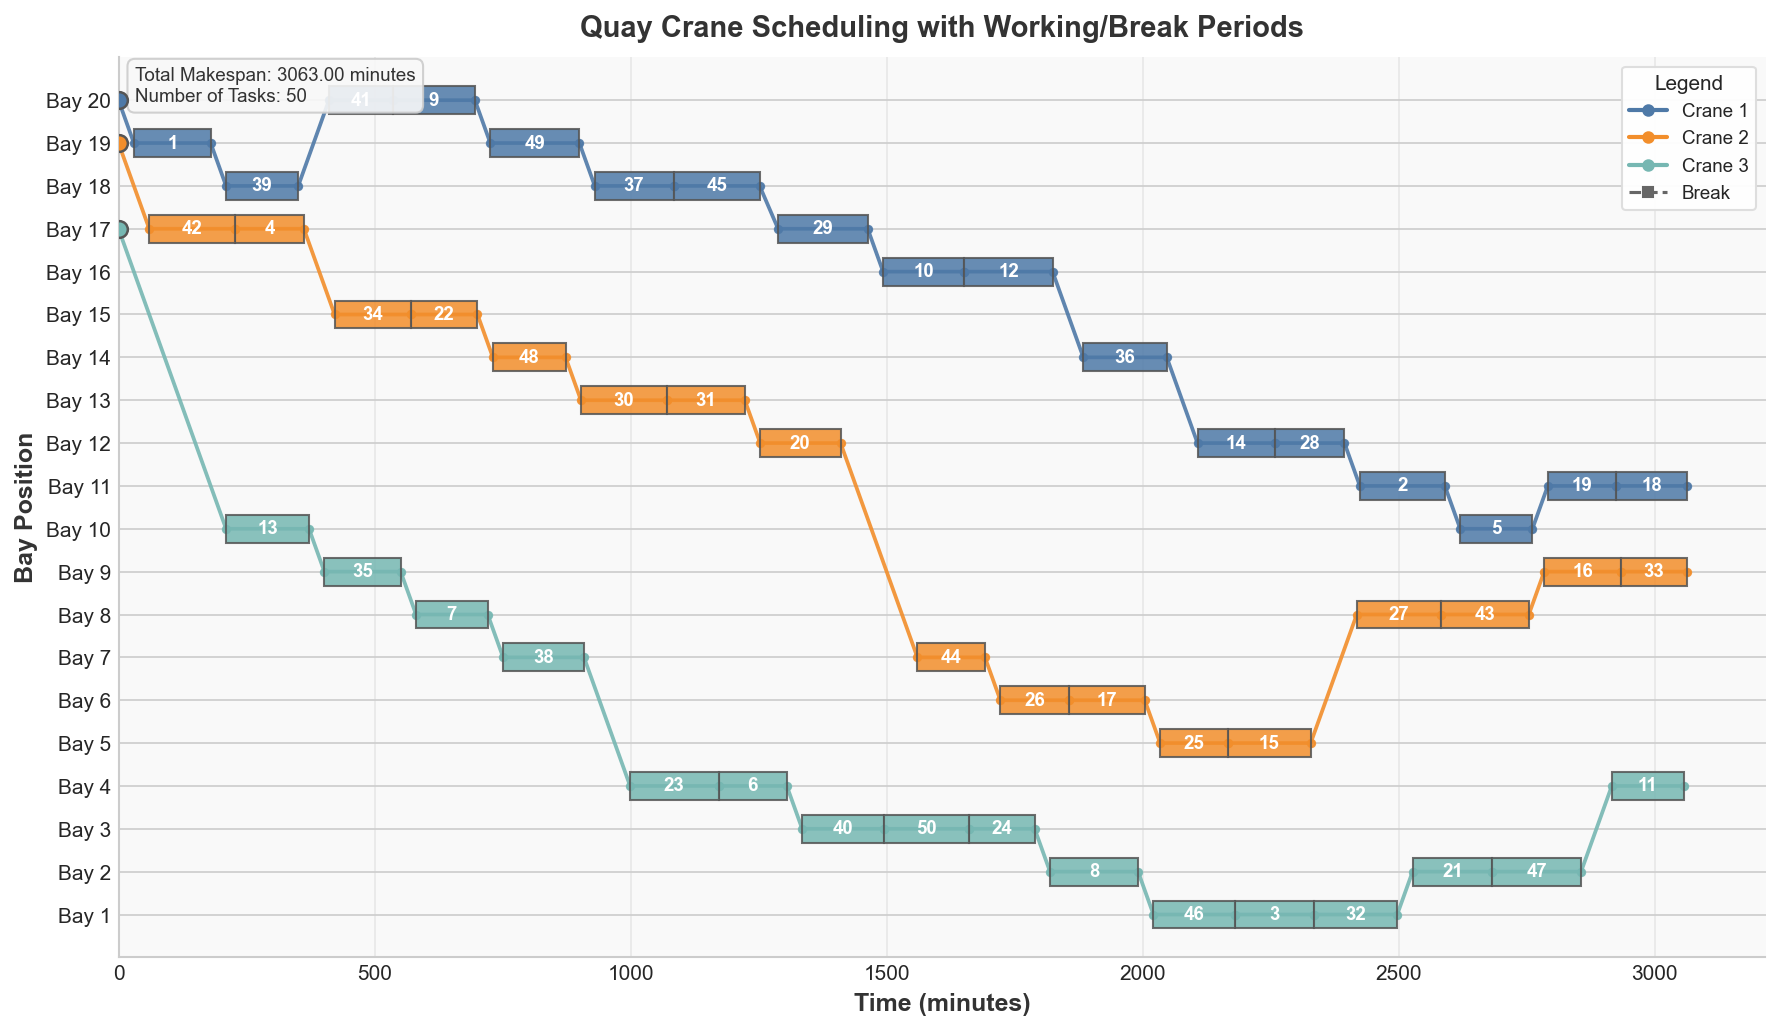


=== 调度结果详情 ===
总完工时间: 3063.00 分钟
求解时间: 120.83 秒

任务分配:
岸桥 1: 17 个任务
  任务 1: 30.00 - 180.00 (贝位 19)
  任务 39: 210.00 - 351.00 (贝位 18)
  任务 41: 411.00 - 536.00 (贝位 20)
  任务 9: 536.00 - 696.00 (贝位 20)
  任务 49: 726.00 - 900.00 (贝位 19)
  任务 37: 930.00 - 1084.00 (贝位 18)
  任务 45: 1084.00 - 1252.00 (贝位 18)
  任务 29: 1288.00 - 1463.00 (贝位 17)
  任务 10: 1493.00 - 1652.00 (贝位 16)
  任务 12: 1652.00 - 1824.00 (贝位 16)
  任务 36: 1884.00 - 2047.00 (贝位 14)
  任务 14: 2107.00 - 2259.00 (贝位 12)
  任务 28: 2259.00 - 2394.00 (贝位 12)
  任务 2: 2424.00 - 2590.00 (贝位 11)
  任务 5: 2620.00 - 2761.00 (贝位 10)
  任务 19: 2791.00 - 2924.00 (贝位 11)
  任务 18: 2924.00 - 3063.00 (贝位 11)
岸桥 2: 17 个任务
  任务 42: 60.00 - 228.00 (贝位 17)
  任务 4: 228.00 - 362.00 (贝位 17)
  任务 34: 422.00 - 571.00 (贝位 15)
  任务 22: 571.00 - 701.00 (贝位 15)
  任务 48: 731.00 - 873.00 (贝位 14)
  任务 30: 903.00 - 1071.00 (贝位 13)
  任务 31: 1071.00 - 1223.00 (贝位 13)
  任务 20: 1253.00 - 1410.00 (贝位 12)
  任务 44: 1560.00 - 1692.00 (贝位 7)
  任务 26: 1722.00 - 1856.00 (贝位 6)
  任务

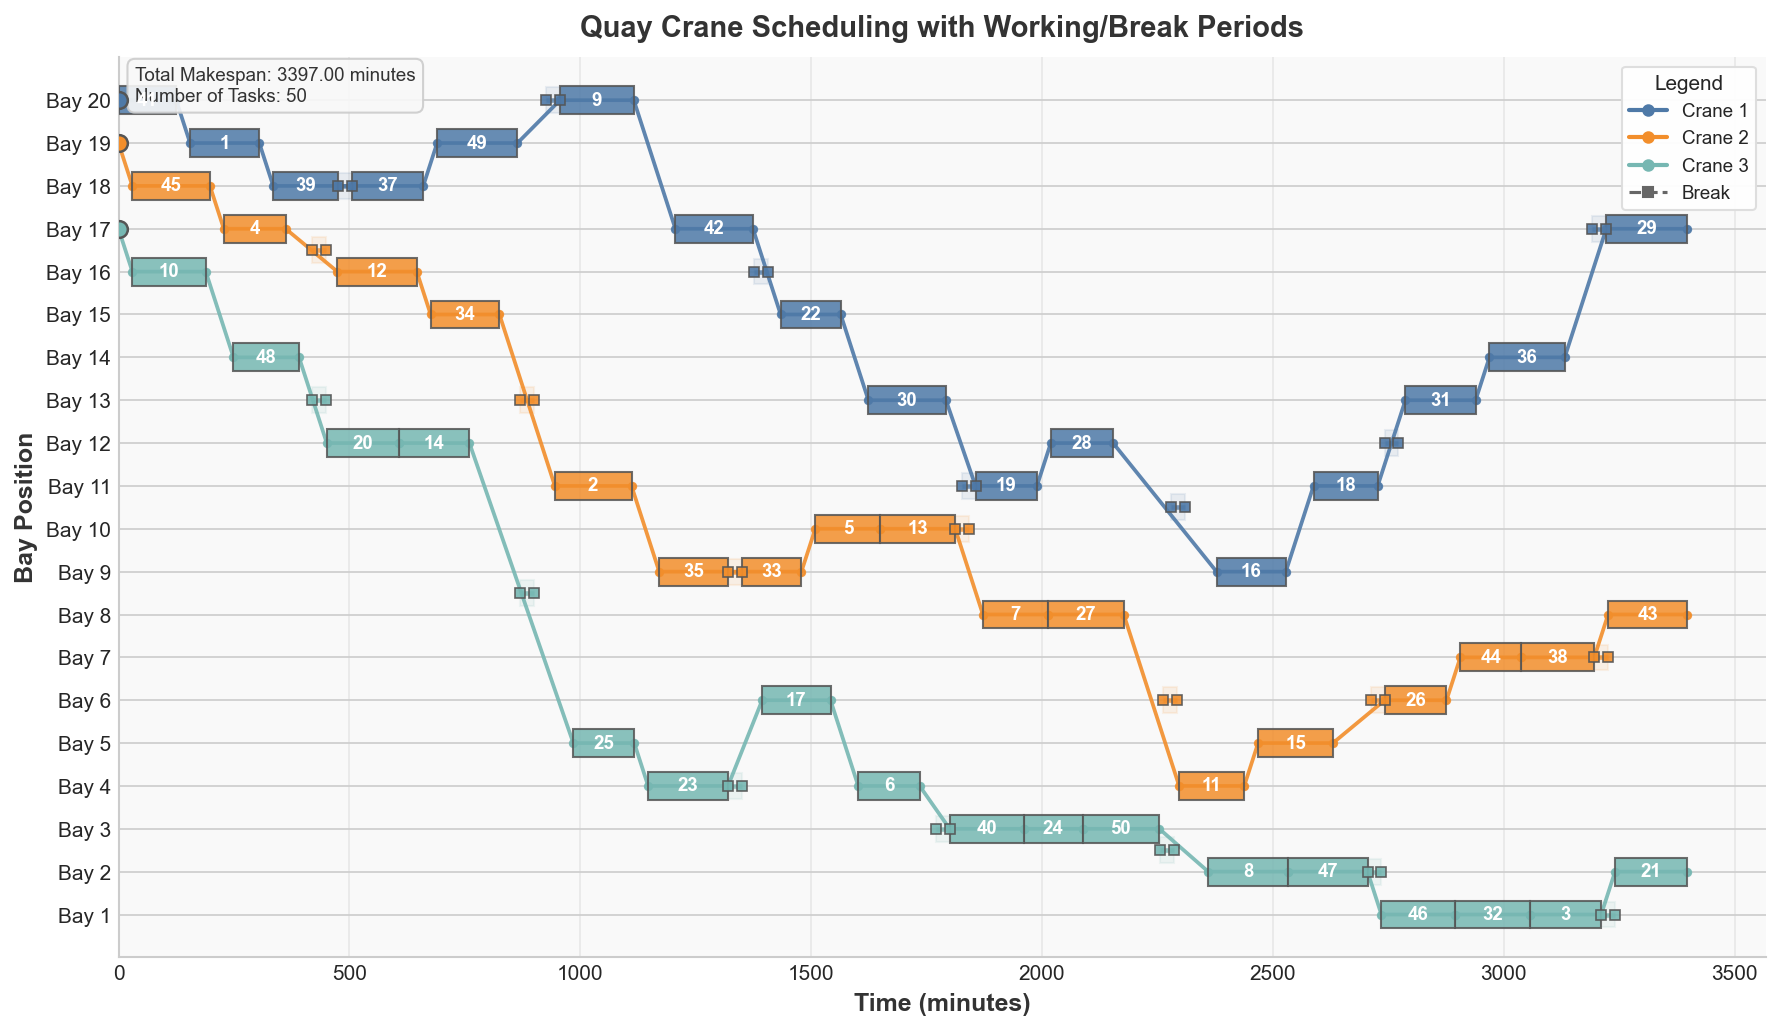


=== 调度结果详情 ===
总完工时间: 3397.00 分钟
求解时间: 121.05 秒

工作休息安排:
岸桥 1:
  工作周期 1: 0.00 - 476.00
  休息时间: 476.00 - 506.00
  工作周期 2: 506.00 - 926.00
  休息时间: 926.00 - 956.00
  工作周期 3: 956.00 - 1376.00
  休息时间: 1376.00 - 1406.00
  工作周期 4: 1406.00 - 1826.00
  休息时间: 1826.00 - 1856.00
  工作周期 5: 1856.00 - 2280.00
  休息时间: 2280.00 - 2310.00
  工作周期 6: 2310.00 - 2742.00
  休息时间: 2742.00 - 2772.00
  工作周期 7: 2772.00 - 3192.00
  休息时间: 3192.00 - 3222.00
  工作周期 8: 3222.00 - 3642.00
  休息时间: 3642.00 - 3672.00
  工作周期 9: 3672.00 - 4152.00
  休息时间: 4152.00 - 4182.00
  工作周期 10: 4182.00 - 4530.00
岸桥 2:
  工作周期 1: 0.00 - 420.00
  休息时间: 420.00 - 450.00
  工作周期 2: 450.00 - 870.00
  休息时间: 870.00 - 900.00
  工作周期 3: 900.00 - 1320.00
  休息时间: 1320.00 - 1350.00
  工作周期 4: 1350.00 - 1812.00
  休息时间: 1812.00 - 1842.00
  工作周期 5: 1842.00 - 2262.00
  休息时间: 2262.00 - 2292.00
  工作周期 6: 2292.00 - 2712.00
  休息时间: 2712.00 - 2742.00
  工作周期 7: 2742.00 - 3196.00
  休息时间: 3196.00 - 3226.00
  工作周期 8: 3226.00 - 3646.00
  休息时间: 3646.00 - 3676.00
  工作周

In [ ]:
main()

## 启发式求解

### 运行

In [16]:
main()

=== 岸桥调度问题求解 (带工作休息和稳定性约束) ===

加载现有数据...

=== 策略1: 基本岸桥调度模型（无约束）===
使用启发式算法求解岸桥调度问题 (稳定性约束: False, 工作休息约束: False)
使用双目标进化算法(BiEA)求解...
求解过程出现错误: 30


Traceback (most recent call last):
  File "C:\Users\27497\AppData\Local\Temp\ipykernel_22860\925504110.py", line 690, in solve_quay_crane_scheduling_with_breaks_heuristic
    best_solution = biea_main()
                    ^^^^^^^^^^^
  File "C:\Users\27497\AppData\Local\Temp\ipykernel_22860\925504110.py", line 576, in biea_main
    child = crossover(parent1, parent2)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\27497\AppData\Local\Temp\ipykernel_22860\925504110.py", line 338, in crossover
    current = mapping[current]
              ~~~~~~~^^^^^^^^^
KeyError: 30
